# Model Selection

##### *In which we choose the best model to predict the age of a crab.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/1-models)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/1-models/models.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


## Table of Contents

1. [Define Constants](#Define-Constants)
2. [Import Libraries](#Import-Libraries)
3. [Load Data from Cache](#Load-Data-from-Cache)
4. [Split the Data](#Split-the-Data)
5. [Metrics Used](#Metrics-Used)
6. [Model Exploration](#Model-Exploration)
    1. [Naive Linear Regression](#Naive-Linear-Regression)
    2. [Neural Network Model](#Neural-Network-Model)
    3. [Neural Network Model (32-16-8-1)](#Neural-Network-Model-(32-16-8-1))
    4. [Neural Network Model (16-8-1)](#Neural-Network-Model-(16-8-1))
    5. [Neural Network Model (8-1)](#Neural-Network-Model-(8-1))
    6. [Neural Network Model (4-1)](#Neural-Network-Model-(4-1))
    7. [Neural Network Model (2-1)](#Neural-Network-Model-(2-1))
    8. [True vs Predicted Age Scatter Plots](#True-vs-Predicted-Age-Scatter-Plots)
    9. [Training Loss Over Time Plots](#Training-Loss-Over-Time-Plots)
    10. [Re-Train the Models Again](#Re-Train-the-Models-Again)
    11. [Re-Plot the Training Loss Over Time](#Re-Plot-the-Training-Loss-Over-Time)
        1. [Training Loss Over More Time Observations](#Training-Loss-Over-More-Time-Observations)
7. [Model Leaderboard](#Model-Leaderboard)
    1. [My Criteria](#My-Criteria)
    2. [Putting it All Together](#Putting-it-All-Together)
    3. [Reminder of Our Metrics](#Reminder-of-Our-Metrics)
    4. [Model Type Comparison](#Model-Type-Comparison)
    5. [Show the Leaderboard Again](#Show-the-Leaderboard-Again)
8. [Choose the Best Architecture for the Job](#Choose-the-Best-Architecture-for-the-Job)
9. [Hyperparameter Tuning](#Hyperparameter-Tuning)
    1. [Hyperparameters](#Hyperparameters)
    2. [Optimizer Tuning](#Optimizer-Tuning)
    3. [Optimizer Decision](#Optimizer-Decision)
    4. [Learning Rate Tuning](#Learning-Rate-Tuning)
    5. [Learning Rate Decision](#Learning-Rate-Decision)
    6. [Loss Function to Mean Absolute Error](#Loss-Function-to-Mean-Absolute-Error)
    7. [Perhaps an Ensemble Will Help](#Perhaps-an-Ensemble-Will-Help)
10. [Winner, Winner, Crab's for Dinner!](#Winner,-Winner,-Crab's-for-Dinner!)
11. [Save the Data](#Save-the-Data)
12. [Onwards to Feature Engineering](#Onwards-to-Feature-Engineering)


### Define Constants


In [1]:
%%time
CACHE_FILE = '../cache/crabs.feather'
NEXT_CACHE_FILE = '../cache/splitcrabs.feather'
NEXT_NOTEBOOK = '../2-features/features.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/best_model.weights.h5'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries


In [2]:
%%time
from notebooks.time_for_crab.mlutils import display_df, generate_neural_pyramid
from notebooks.time_for_crab.mlutils import plot_training_loss, plot_training_loss_from_dict, plot_true_vs_pred_from_dict
from notebooks.time_for_crab.mlutils import score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task
elif keras_backend == 'jax':
    import jax
    print(f'JAX version: {jax.__version__}')
    print(f'JAX devices: {jax.devices()}')
else:
    print('Unknown backend; Proceed with caution.')

import numpy as np
import pandas as pd

from typing import Generator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 516 ms
Wall time: 2.22 s


### Load Data from Cache

In the [previous section](../0-eda/overfit.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [3]:
%%time
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs, show_distinct=True)


DataFrame shape: (3790, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3790 non-nul

### Split the Data

Let's split the data into training and testing sets.

It is important to split the data before any data augmentation or normalization to avoid data leakage.  
Data leakage lets the model learn from the testing data, which can lead to overfitting.

In more general terms, *data leakage* is the phenomenon when the form of a label "leaks" into the training feature set.
An example this of occurred in 2021 for diagnosing Covid patients. Patients lying down on a bed were more likely to be "diagnosed" with Covid.
This is because patients confirmed to have Covid were more inclined to bed rest (Huyen, 2022). 

#### Importance of Data Shuffling

Shuffling the data is important to avoid any biases in the data.
The order of data shouldn't matter, so shuffling helps mitigate any biases.

Shuffling should occur before the test-train split to be most effective.

We don't have to worry about time-series data right now
(although we could reverse order by 'Age' and call it time-series by new feature 'Crab Birthdate'),
but shuffling can have a big impact on the model's performance.


In [4]:
%%time
# split features from target
X = crabs.drop([PREDICTION_TARGET], axis=1)
y = crabs[PREDICTION_TARGET]

# 80% training, 20% testing
train_size = int((1. - VALIDATION_SPLIT) * len(X))

# shuffle the data
random_indices = np.random.default_rng(42).permutation(np.arange(len(X)))

# split into train/test sets
X_train = X.iloc[random_indices[1:train_size]]
X_test = X.drop(X_train.index)
y_train = y.iloc[random_indices[1:train_size]]
# save the prediction target
y_test = y.drop(y_train.index)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')


X_train: (3031, 10)
X_test: (759, 10)
CPU times: total: 15.6 ms
Wall time: 2.01 ms


## Metrics Used

Throughout this notebook, we will use the following metrics to evaluate the regression model:

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.


## Model Exploration

So far, we have not done any feature engineering, which can often be the most important part of the process.
Some new features could be constructed from our dataset which would call for a different model.
Nonetheless, we can start by using all features to set a baseline.
 
We will start with a few simple models to get a baseline accuracy.

We will use the following models:
- Naive Random Baseline
- Linear Regression
- Neural Networks
    - (64-32-16-8-1)
    - (32-16-8-1)
    - (16-8-1)
    - (8-1)
    - (4-1)
    - (2-1) 

### Naive Linear Regression

The simplest model is a naive linear regression model. It is untrained and will make random guesses.


In [5]:
%%time
# layer: input
layer_feature_input = keras.layers.Input(shape=(len(X_train.columns),))

# layer: normalizer
layer_feature_normalizer = keras.layers.Normalization(axis=-1)
layer_feature_normalizer.adapt(np.array(X_train))

# layer: output (linear regression)
layer_feature_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> linear
# initialize the all_models dictionary
all_models = {'linear': keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    layer_feature_output])}

all_models['linear'].summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32 (132.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 49.6 ms


#### Configure the Linear Model

*These will be used for all models unless otherwise specified.*

- **Optimizer**
    - Adam: Adaptive Moment Estimation [(Kingma & Ba, 2014)](https://arxiv.org/abs/1412.6980)
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint
        - Save the best model weights.

##### Define Common Compile Options
##### Define Common Checkpoint Options


In [6]:
%%time
# some framework
def next_adam(learning_rate:float=0.001) -> Generator[keras.optimizers.Adam, None, None]:
    """Yield the next Adam optimizer with the given learning rate."""
    yield keras.optimizers.Adam(learning_rate=learning_rate)


def common_compile_options(
        optimizer:keras.Optimizer=None,
        loss_metric:str='mean_squared_error'):
    """Return a dictionary of common compile options.

    :param optimizer: The optimizer to use. Defaults to Adam with LR=0.001.
    :param loss_metric: The loss metric to use. Defaults to 'mean_squared_error'.
    """
    return {
        'optimizer': optimizer if optimizer is not None else next(next_adam()),
        'loss': loss_metric
    }


all_models['linear'].compile(**common_compile_options())

common_checkpoint_options = {
    'monitor': 'val_loss',
    'save_best_only': True,
    'save_weights_only': True,
    'mode': 'min'
}
linear_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_linear.weights.h5'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 4.08 ms


#### Score the Linear Model (Before Training)


In [7]:
%%time
untrained_linear_preds = all_models['linear'].predict(X_test).flatten()
# Utility functions imported from mlutils.py
untrained_linear_scores_df = score_model(untrained_linear_preds, np.array(y_test), index='untrained_linear')
# Add it to the leaderboard
leaderboard_df = score_combine(pd.DataFrame(), untrained_linear_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
CPU times: total: 46.9 ms
Wall time: 95.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955


#### Train the Linear Model

##### Define Common Fit Options


In [8]:
%%time
common_fit_options = {
    'x': X_train,
    'y': y_train,
    'epochs': NUM_EPOCHS,
    'verbose': 0,
    'validation_split': VALIDATION_SPLIT
}

linear_history = all_models['linear'].fit(
    **common_fit_options,
    callbacks=[linear_checkpoint]
)


CPU times: total: 1.17 s
Wall time: 7.96 s


#### Score the Linear Model


In [9]:
%%time
linear_preds = all_models['linear'].predict(X_test).flatten()
linear_scores_df = score_model(linear_preds, np.array(y_test), index='linear')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, linear_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
CPU times: total: 31.2 ms
Wall time: 50.7 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,13.846882,3.101748,-0.271429,-3.050076


### Neural Network Model

#### Neural Network Architecture

We will start with a deep (64-32-16-8-1) neural network with a few layers, gradually reducing the complexity from our overfit model.


- **Input Layer**
    - All of the features, please.
- **Normalizer Layer**
    - Adapted to all features in the training data. 
- **Hidden Layers**
    - Four dense layers each with 64 >> {layer_index} units and ReLU activation.
- **Output Layer**
    - Layer with one output.

> *I know what you're thinking*: "Why not start with a simpler model?"
> 
> *My answer to that*: This is for science, and we're going to test them all anyway. It's sometimes easier to copy and delete than it is to build from scratch. 


In [10]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 64, 32, 16, 8
num_hidden_layers = 4
num_units = 64
layer_deepest_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_deepest_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['64_32_16_8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_deepest_hidden_relu_list,
    layer_deepest_output])

all_models['64_32_16_8_1'].summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,478 (13.59 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 31.2 ms
Wall time: 26.4 ms


#### Configure the Neural Network Model

- **Optimizer**
    - Adam: Adaptive Moment Estimation [(Kingma & Ba, 2014)](https://arxiv.org/abs/1412.6980)
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint


In [11]:
%%time
all_models['64_32_16_8_1'].compile(**common_compile_options())

deepest_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_deep.weights.h5'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 999 µs


#### Train the Neural Network Model

*We're not going to predict with the untrained model, as we already have a random baseline on the leaderboard.*


In [12]:
%%time
deepest_history = all_models['64_32_16_8_1'].fit(
    **common_fit_options,
    callbacks=[deepest_checkpoint]
)


CPU times: total: 3.12 s
Wall time: 9.52 s


#### Score the Neural Network Model


In [13]:
%%time
deepest_preds = all_models['64_32_16_8_1'].predict(X_test).flatten()
deepest_scores_df = score_model(deepest_preds, np.array(y_test), index='64_32_16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deepest_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CPU times: total: 15.6 ms
Wall time: 112 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,13.846882,3.101748,-0.271429,-3.050076
64_32_16_8_1,3.817358,1.467448,0.254447,0.244559


### Neural Network Model (32-16-8-1)

Let's cut the first layer out and see if it still has what it takes.


In [14]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 32, 16, 8
num_hidden_layers = 3
num_units = 32
layer_32_16_8_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_32_16_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['32_16_8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_32_16_8_hidden_relu_list,
    layer_32_16_8_output
])

all_models['32_16_8_1'].summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046 (4.09 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 19.5 ms


#### Configure the (32-16-8-1) Neural Network Model


In [15]:
%%time
all_models['32_16_8_1'].compile(**common_compile_options())

deep_32_16_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_32_16_8.weights.h5'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (32-16-8-1) Neural Network Model

In [16]:
%%time
deep_32_16_8_history = all_models['32_16_8_1'].fit(
    **common_fit_options,
    callbacks=[deep_32_16_8_checkpoint]
)


CPU times: total: 3.12 s
Wall time: 8.73 s


#### Score the (32-16-8-1) Neural Network Model


In [17]:
%%time
deep_32_16_8_preds = all_models['32_16_8_1'].predict(X_test).flatten()
deep_32_16_8_scores_df = score_model(deep_32_16_8_preds, np.array(y_test), index='32_16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_32_16_8_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CPU times: total: 46.9 ms
Wall time: 100 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,13.846882,3.101748,-0.271429,-3.050076
64_32_16_8_1,3.817358,1.467448,0.254447,0.244559
32_16_8_1,3.865034,1.458170,0.217289,0.205298


### Neural Network Model (16-8-1)

The last one held up, so let's reduce it even more.


In [18]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 16, 8
num_hidden_layers = 2
num_units = 16
layer_16_8_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_16_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['16_8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_16_8_hidden_relu_list,
    layer_16_8_output])

all_models['16_8_1'].summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342 (1.34 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 17 ms


#### Configure the (16-8-1) Neural Network Model


In [19]:
%%time
all_models['16_8_1'].compile(**common_compile_options())

deep_16_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_16_8.weights.h5'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (16-8-1) Neural Network Model


In [20]:
%%time
deep_16_8_history = all_models['16_8_1'].fit(
    **common_fit_options,
    callbacks=[deep_16_8_checkpoint]
)


CPU times: total: 2.72 s
Wall time: 8.28 s


#### Score the (16-8-1) Neural Network Model


In [21]:
%%time
deep_16_8_preds = all_models['16_8_1'].predict(X_test).flatten()
deep_16_8_scores_df = score_model(deep_16_8_preds, np.array(y_test), index='16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_16_8_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 89.2 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,13.846882,3.101748,-0.271429,-3.050076
64_32_16_8_1,3.817358,1.467448,0.254447,0.244559
32_16_8_1,3.865034,1.458170,0.217289,0.205298
16_8_1,3.789348,1.427520,0.205606,0.204062


### Neural Network Model (8-1)

The last reduction didn't lose too much accuracy, so let's continue removing layers.


In [22]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 8
num_hidden_layers = 1
num_units = 8
layer_8_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['8_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_8_hidden_relu_list,
    layer_8_output])

all_models['8_1'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (476.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 13.8 ms


#### Configure the (8-1) Neural Network Model


In [23]:
%%time
all_models['8_1'].compile(**common_compile_options())

deep_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8.weights.h5'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (8-1) Neural Network Model


In [24]:
%%time
deep_8_history = all_models['8_1'].fit(
    **common_fit_options,
    callbacks=[deep_8_checkpoint]
)


CPU times: total: 2.34 s
Wall time: 8.04 s


#### Score the (8-1) Neural Network Model


In [25]:
%%time
deep_8_preds = all_models['8_1'].predict(X_test).flatten()
deep_8_scores_df = score_model(deep_8_preds, np.array(y_test), index='8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_8_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 15.6 ms
Wall time: 80.6 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,13.846882,3.101748,-0.271429,-3.050076
64_32_16_8_1,3.817358,1.467448,0.254447,0.244559
32_16_8_1,3.865034,1.458170,0.217289,0.205298
16_8_1,3.789348,1.427520,0.205606,0.204062
8_1,3.949430,1.461253,0.084999,0.084404


### Neural Network Model (4-1)

Still not too shabby. Let's reduce the last hidden layer to 4 neurons.


In [26]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 4
num_hidden_layers = 1
num_units = 4
layer_4_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_4_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['4_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_4_hidden_relu_list,
    layer_4_output])

all_models['4_1'].summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70 (284.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 13.5 ms


#### Configure the (4-1) Neural Network Model

In [27]:
%time
all_models['4_1'].compile(**common_compile_options())

deep_4_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_4.weights.h5'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 0 ns


#### Train the (4-1) Neural Network Model

In [28]:
%%time
deep_4_history = all_models['4_1'].fit(
    **common_fit_options,
    callbacks=[deep_4_checkpoint]
)


CPU times: total: 2.7 s
Wall time: 7.97 s


#### Score the (4-1) Neural Network Model

In [29]:
%%time
deep_4_preds = all_models['4_1'].predict(X_test).flatten()
deep_4_scores_df = score_model(deep_4_preds, np.array(y_test), index='4_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_4_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 82.6 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,13.846882,3.101748,-0.271429,-3.050076
64_32_16_8_1,3.817358,1.467448,0.254447,0.244559
32_16_8_1,3.865034,1.458170,0.217289,0.205298
16_8_1,3.789348,1.427520,0.205606,0.204062
8_1,3.949430,1.461253,0.084999,0.084404
4_1,4.196495,1.510384,0.047086,0.047082


### Neural Network Model (2-1)

That last one is even worse than random. Should we even try with 2 neurons? Why not?

In [30]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 2
num_hidden_layers = 1
num_units = 2
layer_2_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_2_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
all_models['2_1'] = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_2_hidden_relu_list,
    layer_2_output])

all_models['2_1'].summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46 (188.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 13.6 ms


#### Configure the (2-1) Neural Network Model

In [31]:
%%time
all_models['2_1'].compile(**common_compile_options())

deep_2_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_2.weights.h5'),
    **common_checkpoint_options
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (2-1) Neural Network Model

In [32]:
%%time
deep_2_history = all_models['2_1'].fit(
    **common_fit_options,
    callbacks=[deep_2_checkpoint]
)


CPU times: total: 2.97 s
Wall time: 8.25 s


#### Score the (2-1) Neural Network Model

In [33]:
%%time
deep_2_preds = all_models['2_1'].predict(X_test).flatten()
deep_2_scores_df = score_model(deep_2_preds, np.array(y_test), index='2_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_2_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 84.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,13.846882,3.101748,-0.271429,-3.050076
64_32_16_8_1,3.817358,1.467448,0.254447,0.244559
32_16_8_1,3.865034,1.458170,0.217289,0.205298
16_8_1,3.789348,1.427520,0.205606,0.204062
8_1,3.949430,1.461253,0.084999,0.084404
4_1,4.196495,1.510384,0.047086,0.047082
2_1,4.096434,1.506417,0.079853,0.079084


### True vs Predicted Age Scatter Plots

This gives us a good view of how well the model is predicting the age of the crabs.


CPU times: total: 15.6 ms
Wall time: 53.1 ms


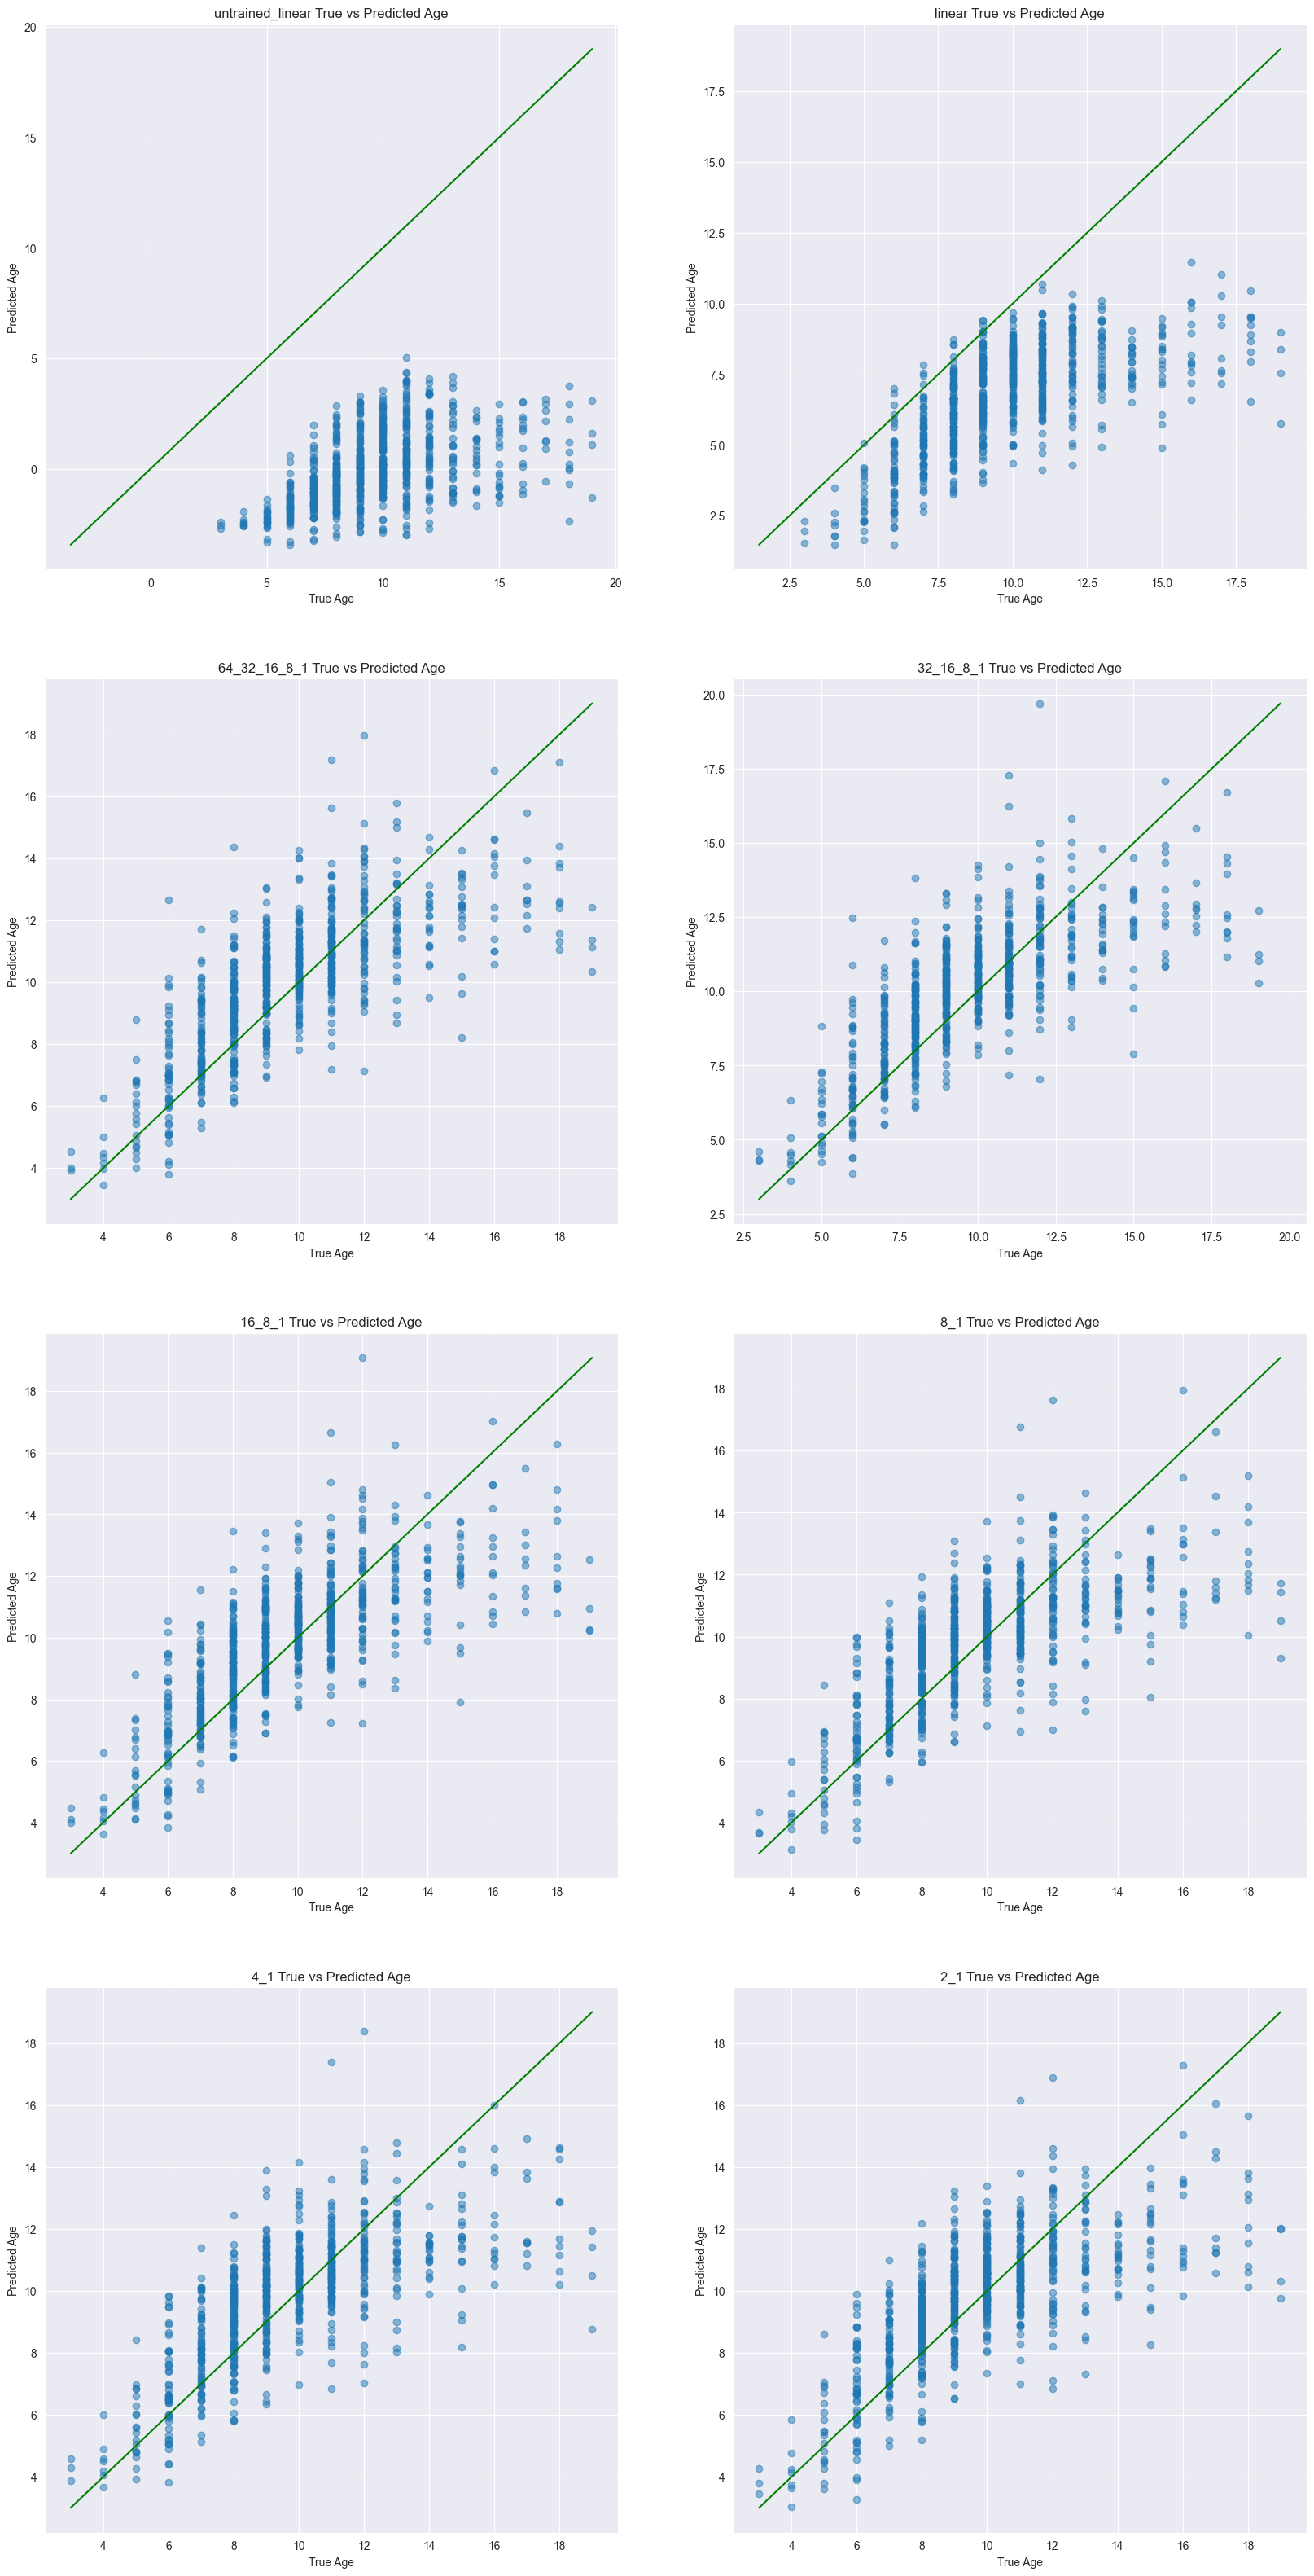

In [34]:
%%time
all_preds = {
    'untrained_linear': {'true': y_test, 'pred': untrained_linear_preds},
    'linear': {'true': y_test, 'pred': linear_preds},
    '64_32_16_8_1': {'true': y_test, 'pred': deepest_preds},
    '32_16_8_1': {'true': y_test, 'pred': deep_32_16_8_preds},
    '16_8_1': {'true': y_test, 'pred': deep_16_8_preds},
    '8_1': {'true': y_test, 'pred': deep_8_preds},
    '4_1': {'true': y_test, 'pred': deep_4_preds},
    '2_1': {'true': y_test, 'pred': deep_2_preds}
}

plot_true_vs_pred_from_dict(all_preds, show_target_line=True)


#### True vs Predicted Age Scatter Plot Observations

Neat!

***Note**: The line of truth is shown in green.*

##### Untrained Linear Model

- Very bad.
    - As usual.
 
##### Linear Model

- Guesses are lower than the actual crab ages.
    - Older crabs may not be harvested soon enough.

##### Neural Network Model (64-32-16-8-1)
##### Neural Network Model (32-16-8-1)
##### Neural Network Model (16-8-1)
##### Neural Network Model (8-1)

- All looking good.
    - Some middle-aged crabs are guessed to be older, but this makes sense since crabs stop growing as much after a certain age.

##### Neural Network Model (4-1)

- Something strange going on here.
    - This model is predicting a disproportionate amount of crabs are 5 years old. 

##### Neural Network Model (2-1)

- Visually similar to the other neural network models.
    - Scores show is making predictions further from the truth.


### Training Loss Over Time Plots

Now we'll show the training loss over time. This gives us insight into how quickly the model is learning. It can also show us if the model is overfitting or not.

Training loss should decrease over time, but if the validation loss starts to increase, the model is overfitting.

CPU times: total: 15.6 ms
Wall time: 56.1 ms


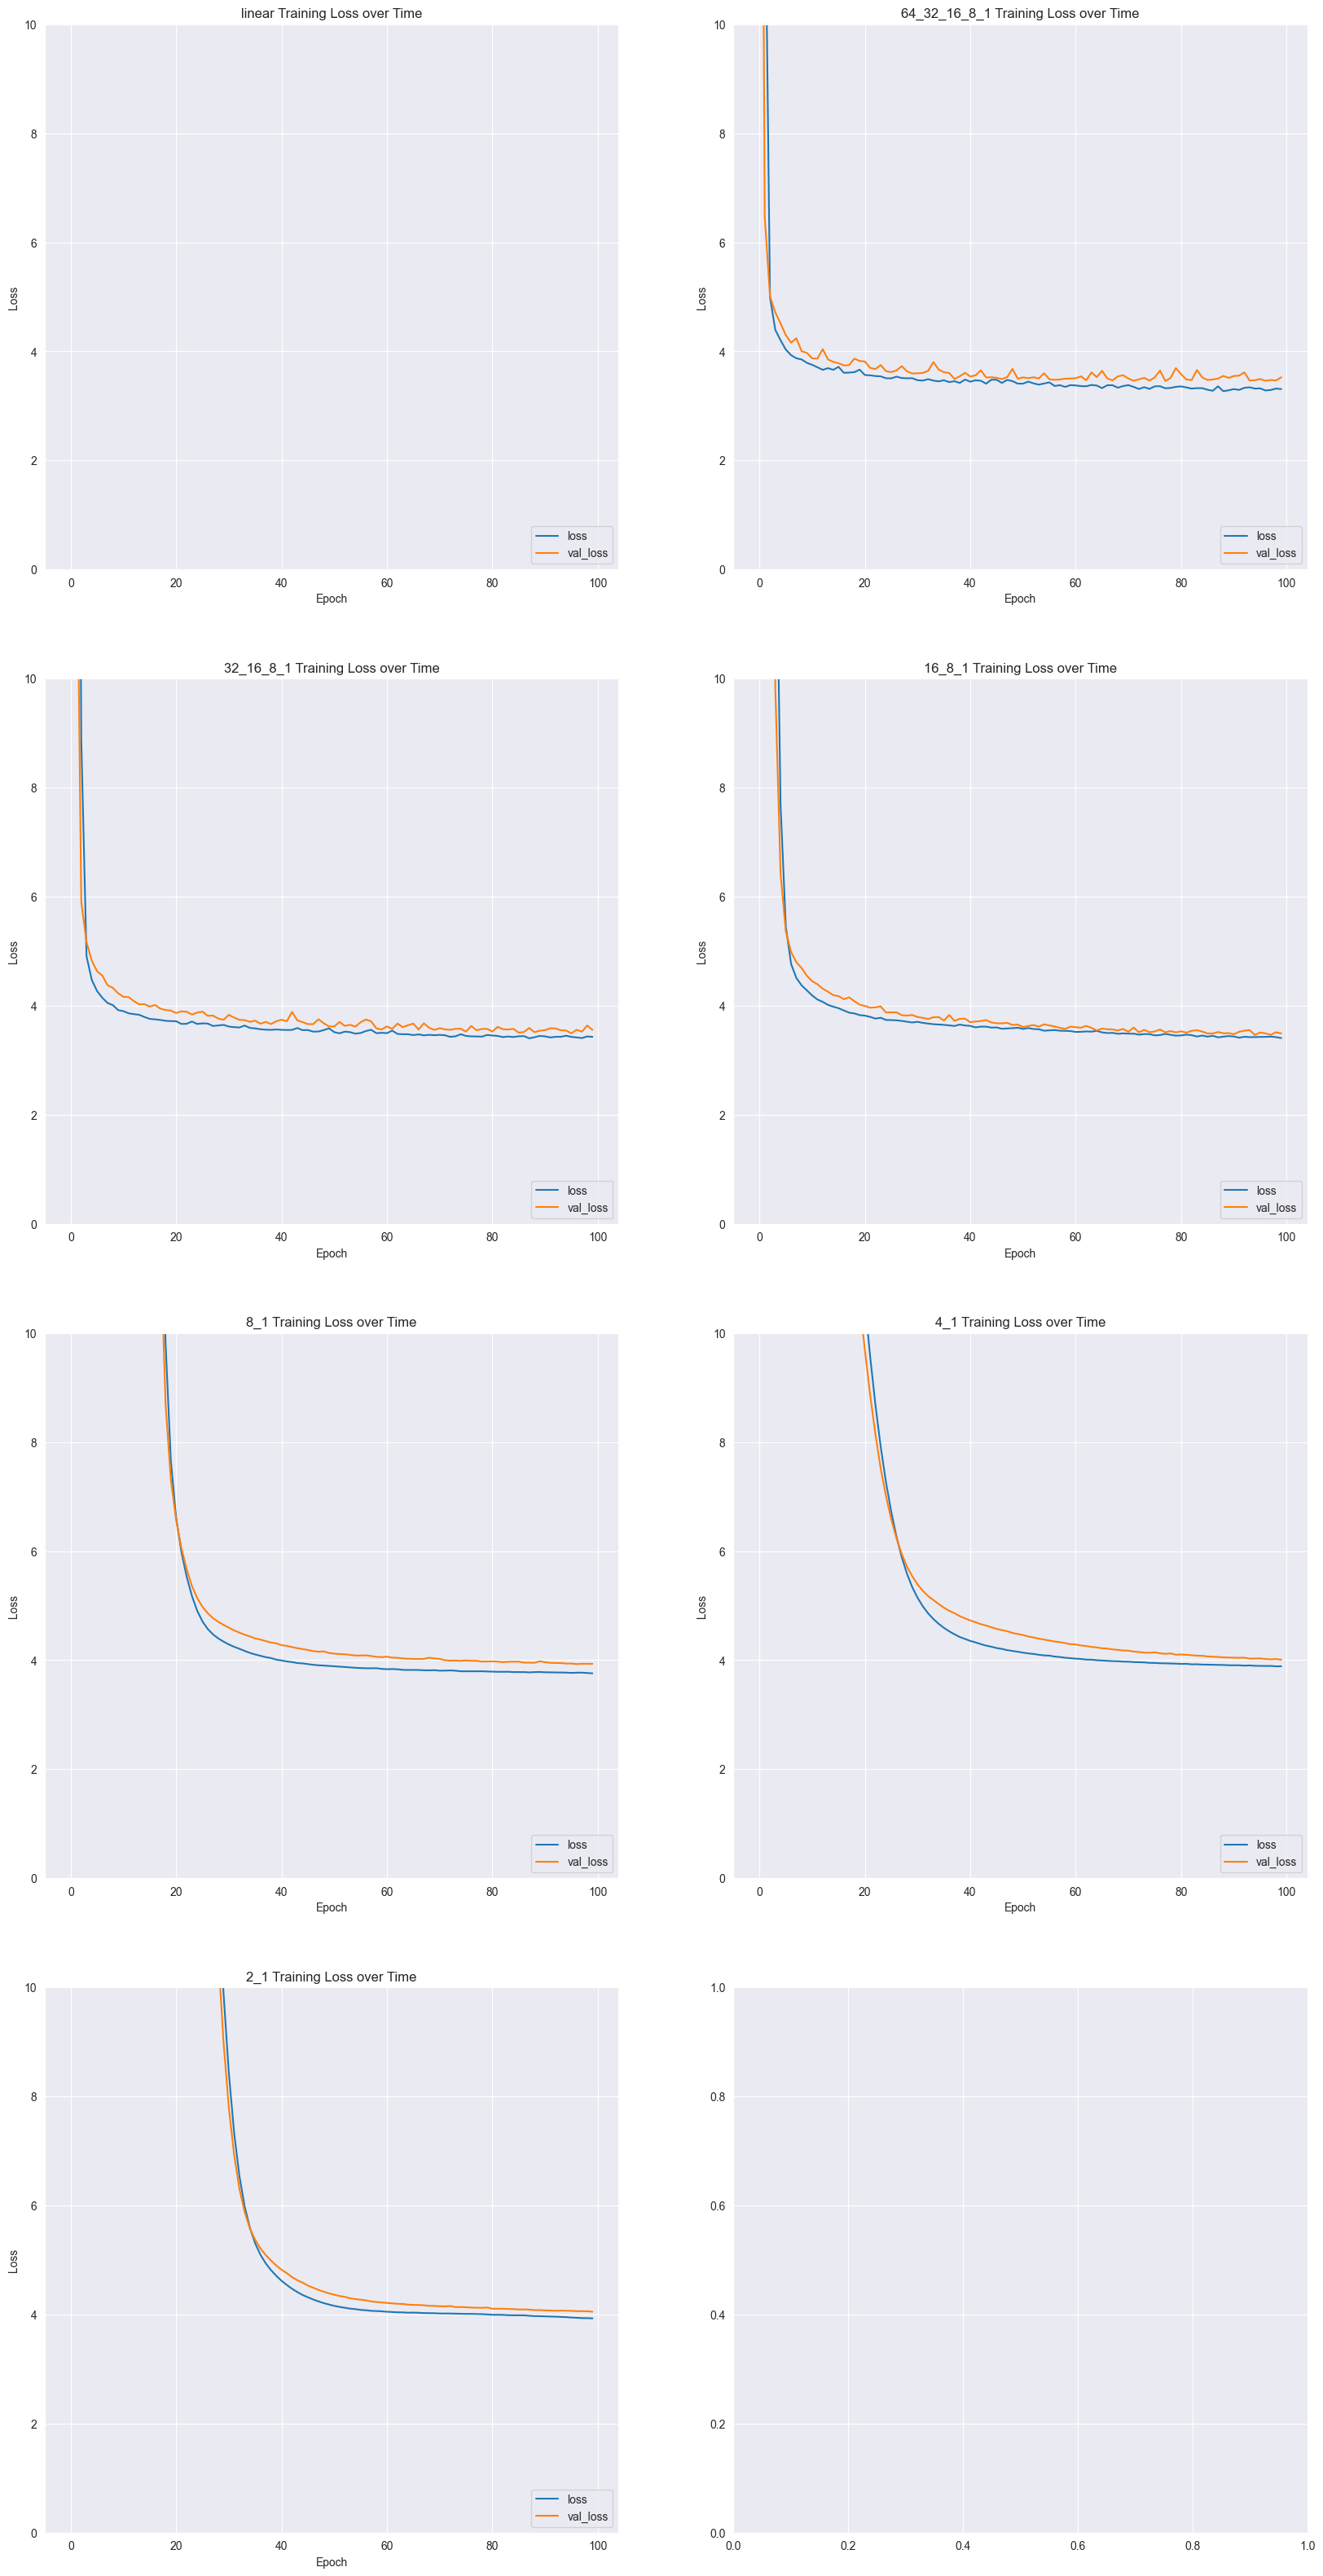

In [35]:
%%time
all_histories = {
    'linear': linear_history,
    '64_32_16_8_1': deepest_history,
    '32_16_8_1': deep_32_16_8_history,
    '16_8_1': deep_16_8_history,
    '8_1': deep_8_history,
    '4_1': deep_4_history,
    '2_1': deep_2_history
}

plot_training_loss_from_dict(all_histories)


#### Training Loss Over Time Observations

Pretty cool, huh?

***Note**: These models have some overhead involved in training, so it's not as simple as "more neurons = better".
Sometimes a simple ML algorithm can do the trick in milliseconds.*

##### Linear Model

- Never even showed up to the party.
- Exceeds a Mean Squared Error of 10.

##### Neural Network Model (64-32-16-8-1)

- Clearly overfitting already.
- Gets the gist quickly.

##### Neural Network Model (32-16-8-1)

- Looking good.
- Also gets to the gist quickly.

##### Neural Network Model (16-8-1)

- Similar to the (32-16-8-1) model.
    - Less variance in the training loss.

##### Neural Network Model (8-1)

- The curve is smoothing out.

##### Neural Network Model (4-1)

- Not as quick to converge.

##### Neural Network Model (2-1)

- Lagging behind.
    - Perhaps more epochs will give this model a chance.
  

### Re-Train the Models Again

Let's start over, but this time for longer.

Give them 5x as many epochs this time.


##### Linear Model

CPU times: total: 7.41 s
Wall time: 34.2 s


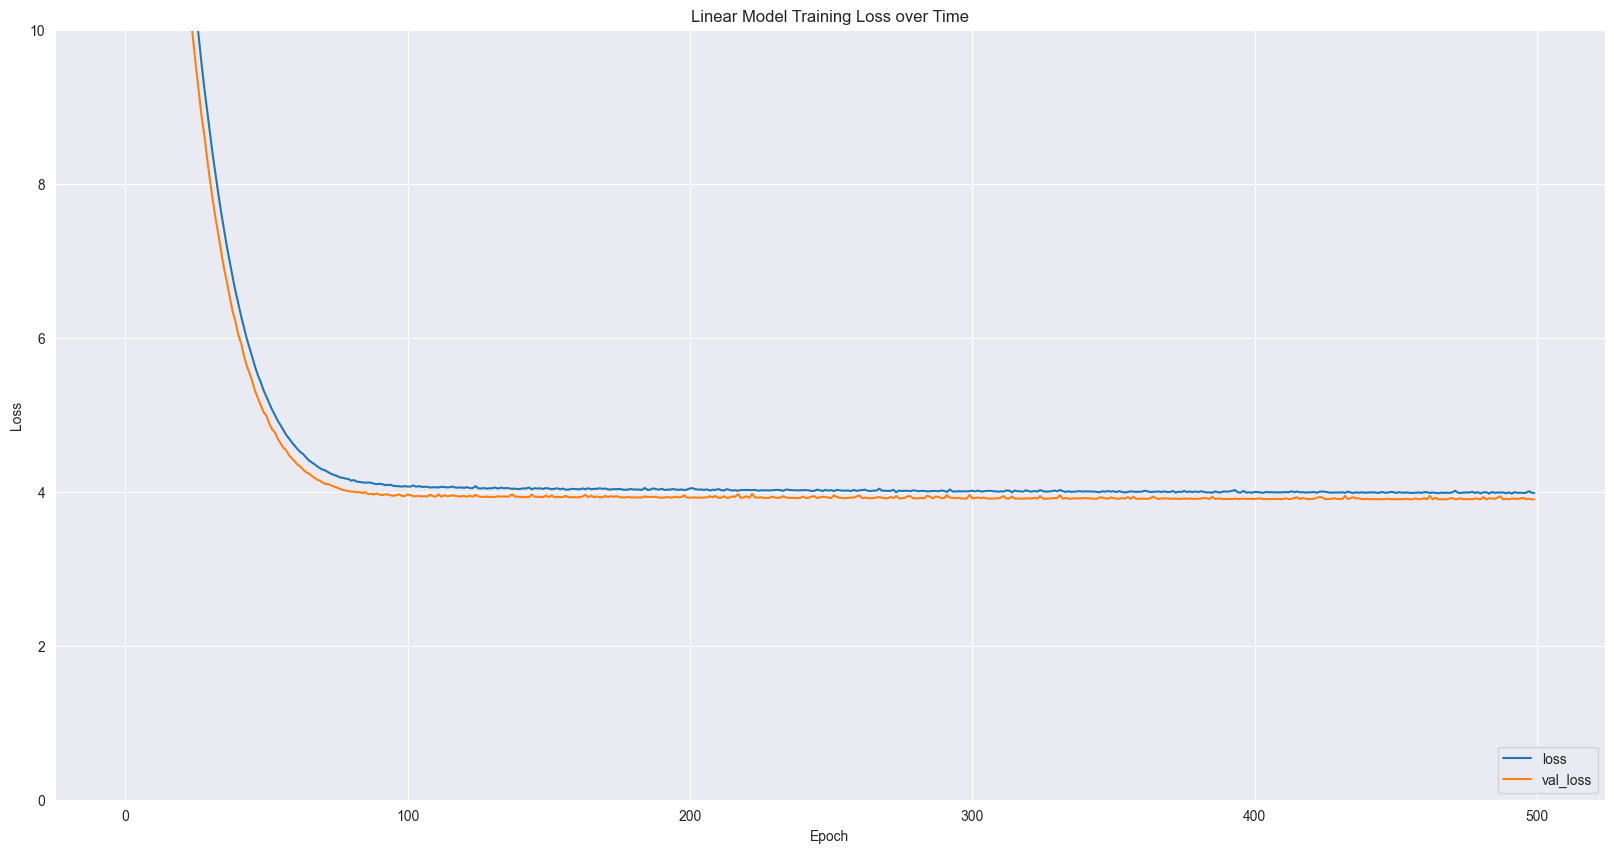

In [36]:
%%time
# add more epochs
#     common_fit_options = {
#         'x': X_train,
#         'y': y_train,
#         'epochs': NUM_EPOCHS*5,
#         'verbose': 0,
#         'validation_split': VALIDATION_SPLIT
#     }
common_fit_options['epochs'] = NUM_EPOCHS*5 # give them 5x as many epochs

# reset the linear model
all_models['linear'] = keras.models.clone_model(all_models['linear'])
all_models['linear'].compile(**common_compile_options())

all_histories.update({'linear': all_models['linear'].fit(
    **common_fit_options,
    callbacks=[linear_checkpoint])})

plot_training_loss(all_histories['linear'], 'Linear Model')


##### Neural Network Model (64-32-16-8-1)

CPU times: total: 8.81 s
Wall time: 39 s


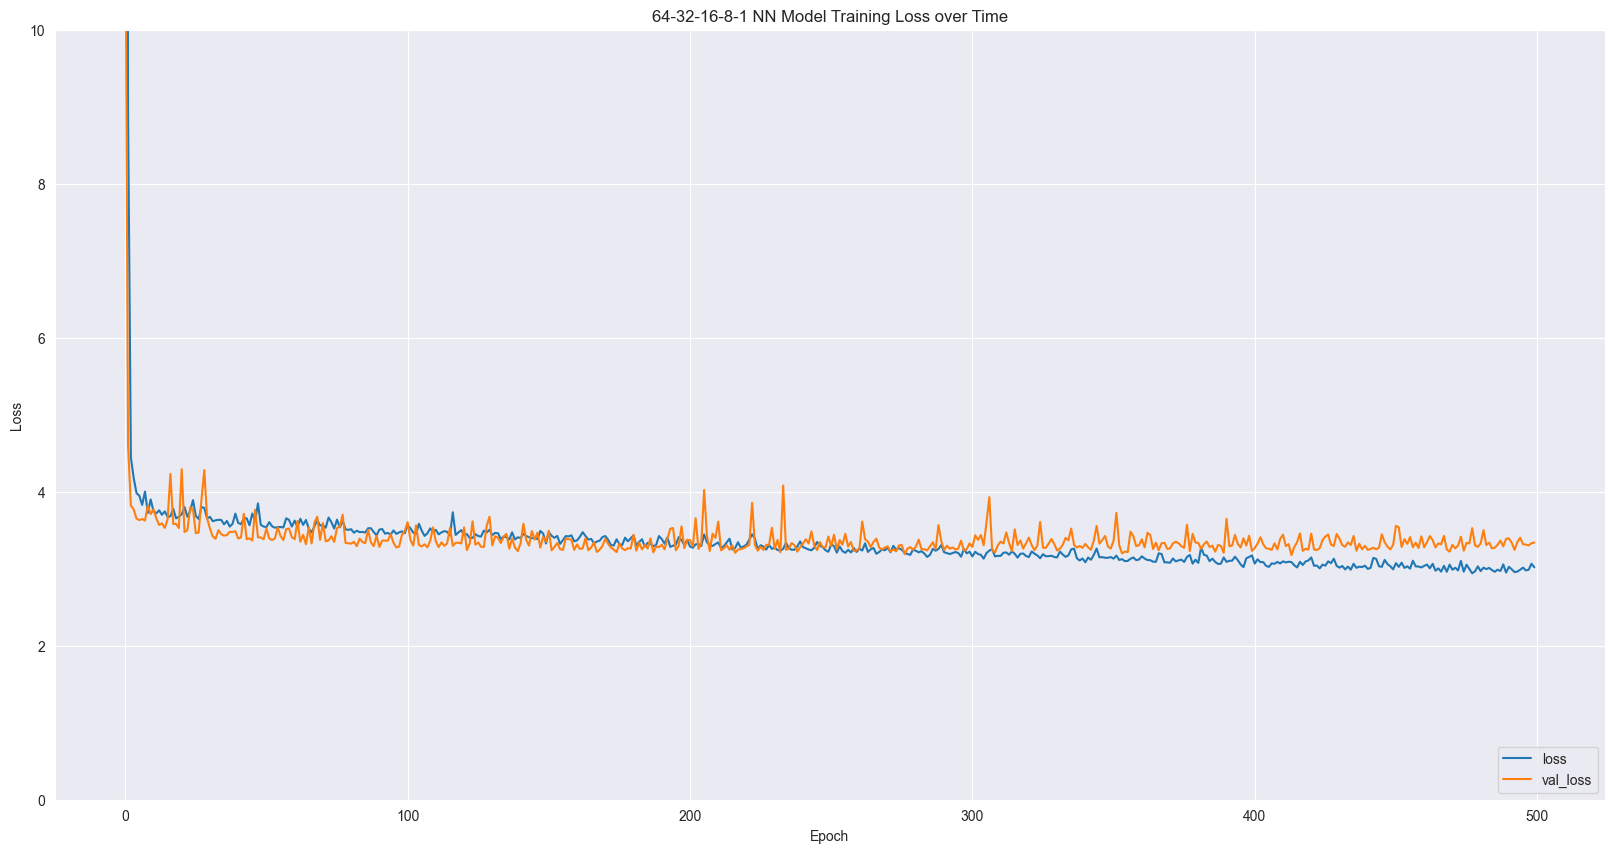

In [37]:
%%time
# reset the (64-32-16-8-1) model
all_models['64_32_16_8_1'] = keras.models.clone_model(all_models['64_32_16_8_1'])
all_models['64_32_16_8_1'].compile(**common_compile_options())

all_histories.update({'64_32_16_8_1':
    all_models['64_32_16_8_1'].fit(
        **common_fit_options,
        callbacks=[deepest_checkpoint])})

plot_training_loss(all_histories['64_32_16_8_1'], '64-32-16-8-1 NN Model')


(64-32-16-8-1) is definitely overfitting. Let's try the next one.

##### Neural Network Model (32-16-8-1)

CPU times: total: 7.8 s
Wall time: 37.5 s


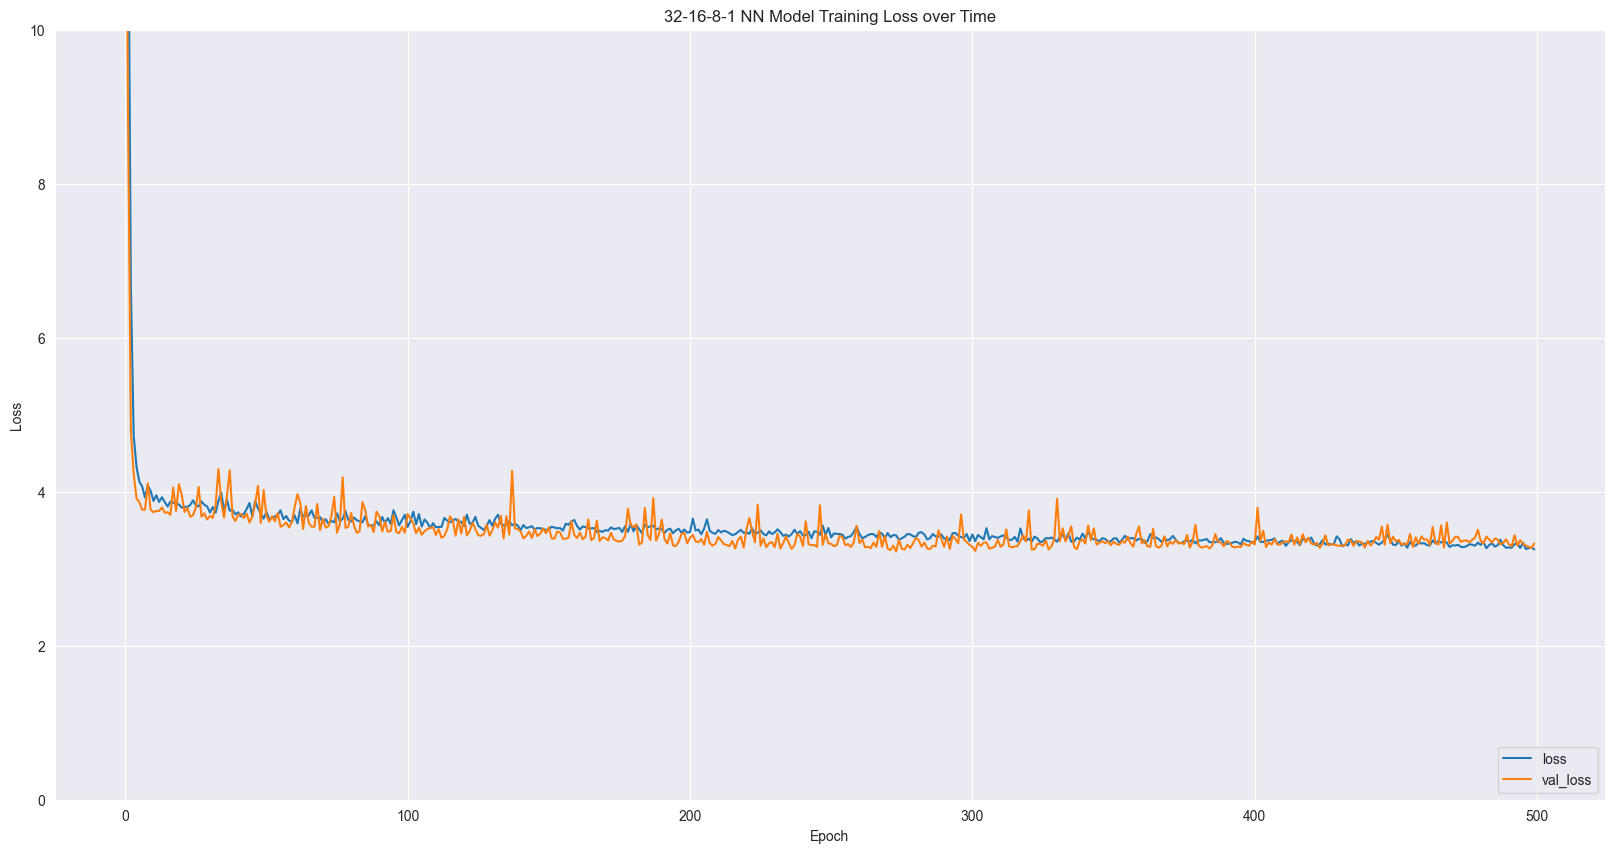

In [38]:
%%time
# reset the (32-16-8-1) model
all_models['32_16_8_1'] = keras.models.clone_model(all_models['32_16_8_1'])
all_models['32_16_8_1'].compile(**common_compile_options())

all_histories.update({'32_16_8_1':
    all_models['32_16_8_1'].fit(
        **common_fit_options,
        callbacks=[deep_32_16_8_checkpoint])})

plot_training_loss(all_histories['32_16_8_1'], '32-16-8-1 NN Model')


(32-16-8-1) still overfitting. Let's keep going.

##### Neural Network Model (16-8-1)

CPU times: total: 8.53 s
Wall time: 36.1 s


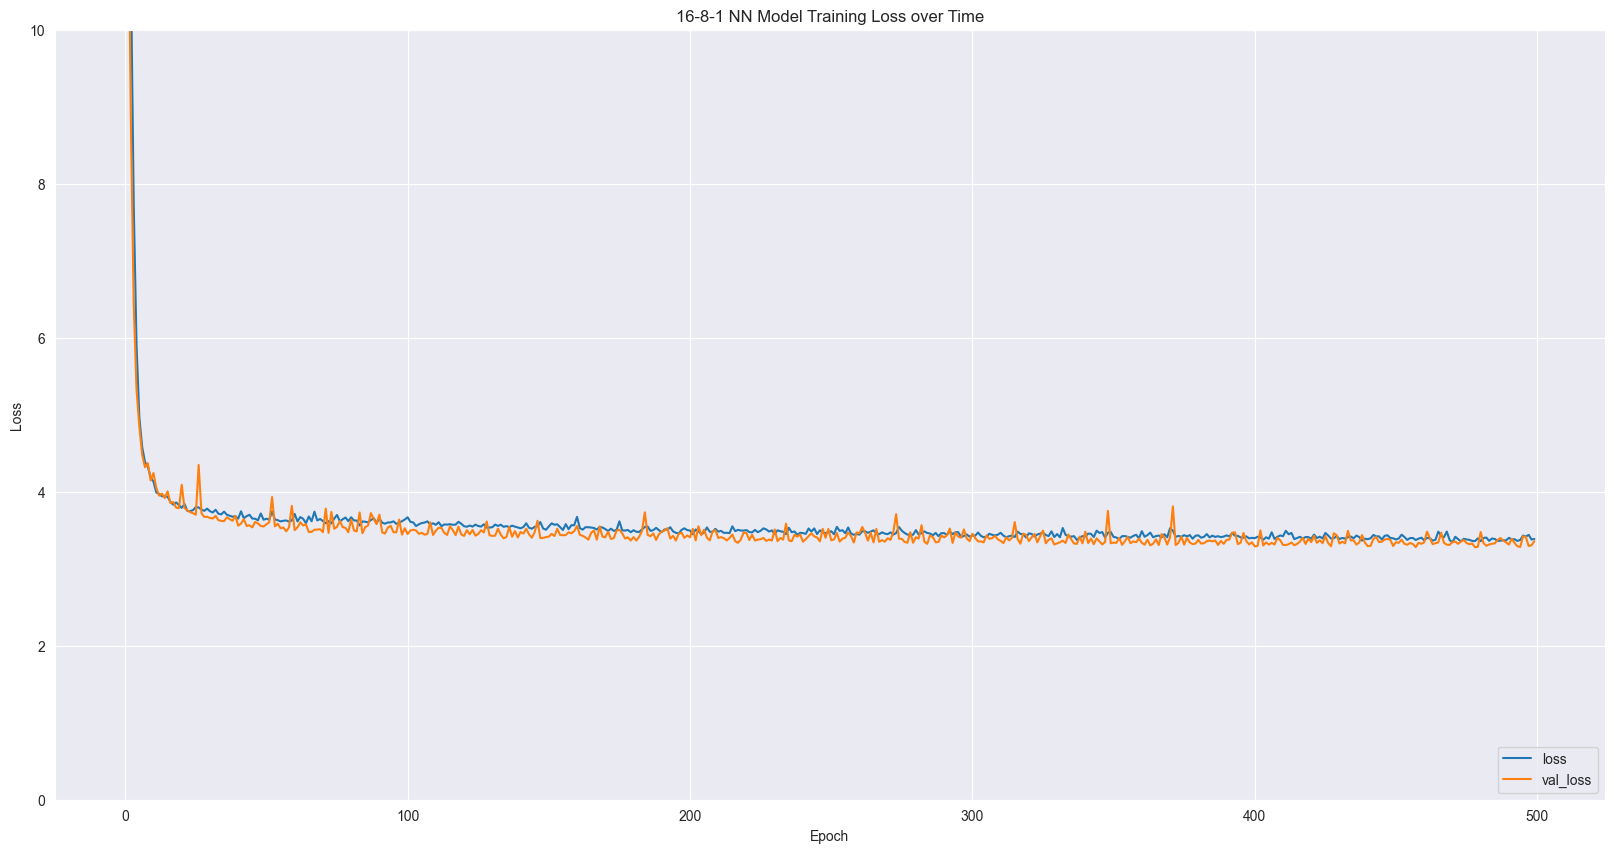

In [39]:
%%time
# reset the (16-8-1) model
all_models['16_8_1'] = keras.models.clone_model(all_models['16_8_1'])
all_models['16_8_1'].compile(**common_compile_options())

all_histories.update({'16_8_1':
    all_models['16_8_1'].fit(
        **common_fit_options,
        callbacks=[deep_16_8_checkpoint])})

plot_training_loss(all_histories['16_8_1'], '16-8-1 NN Model')


Validation loss is remaining steady, and the training loss is decreasing ever so slightly. It *might* be overfitting, but it's hard to tell.

##### Neural Network Model (8-1)

CPU times: total: 8.55 s
Wall time: 35.2 s


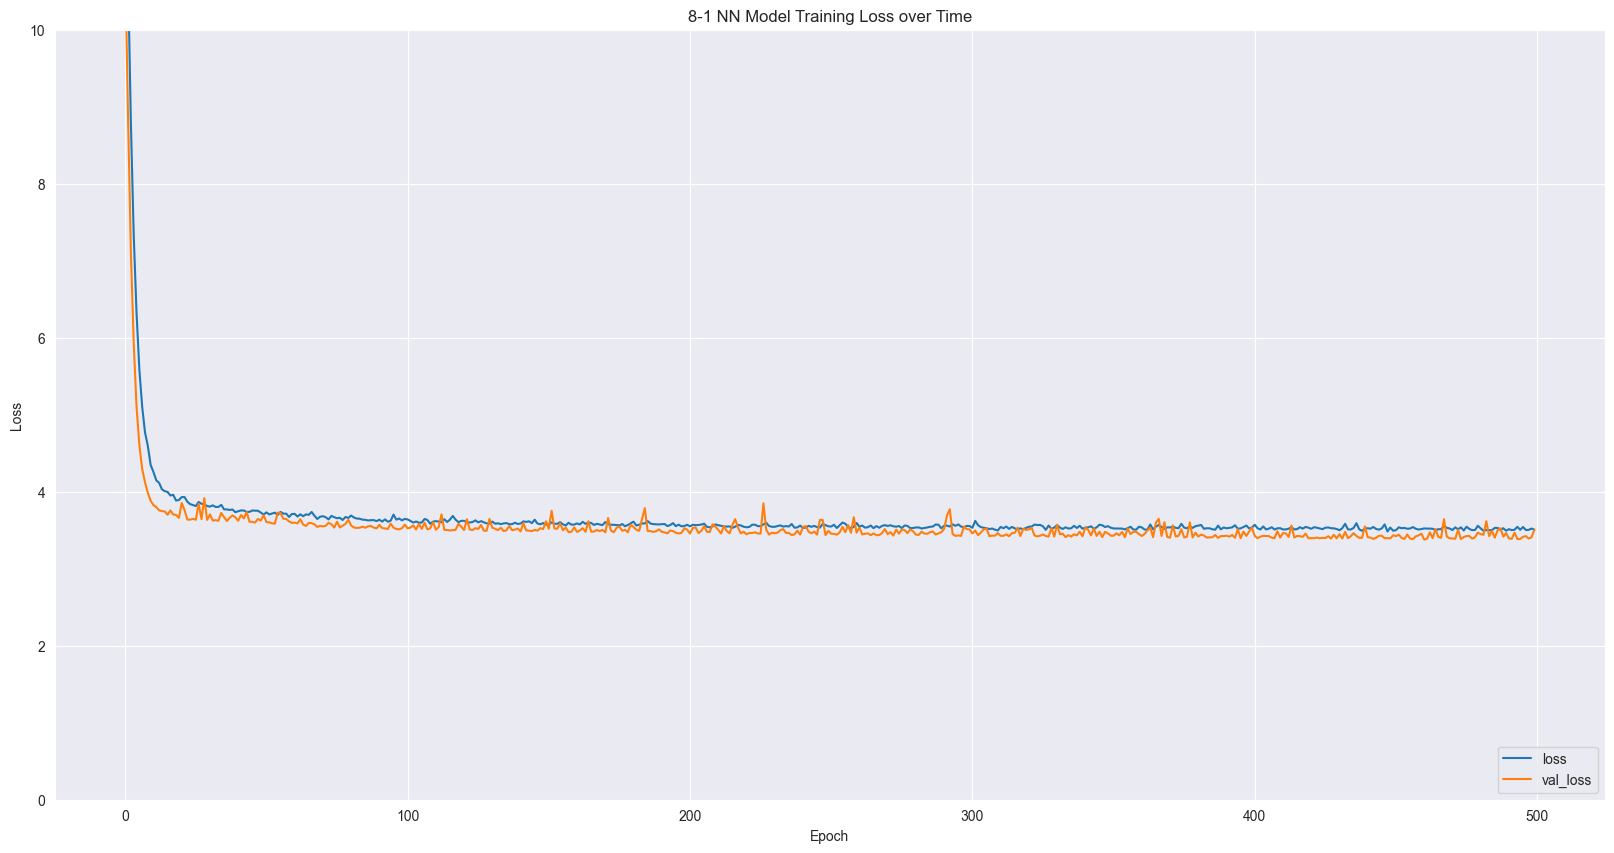

In [40]:
%%time
# reset the (8-1) model
all_models['8_1'] = keras.models.clone_model(all_models['8_1'])
all_models['8_1'].compile(**common_compile_options())

all_histories.update({'8_1':
    all_models['8_1'].fit(
        **common_fit_options,
        callbacks=[deep_8_checkpoint])})

plot_training_loss(all_histories['8_1'], '8-1 NN Model')


(8-1) doesn't seem to be overfitting. Let's keep it in mind.

##### Neural Network Model (4-1)

CPU times: total: 8.33 s
Wall time: 35.4 s


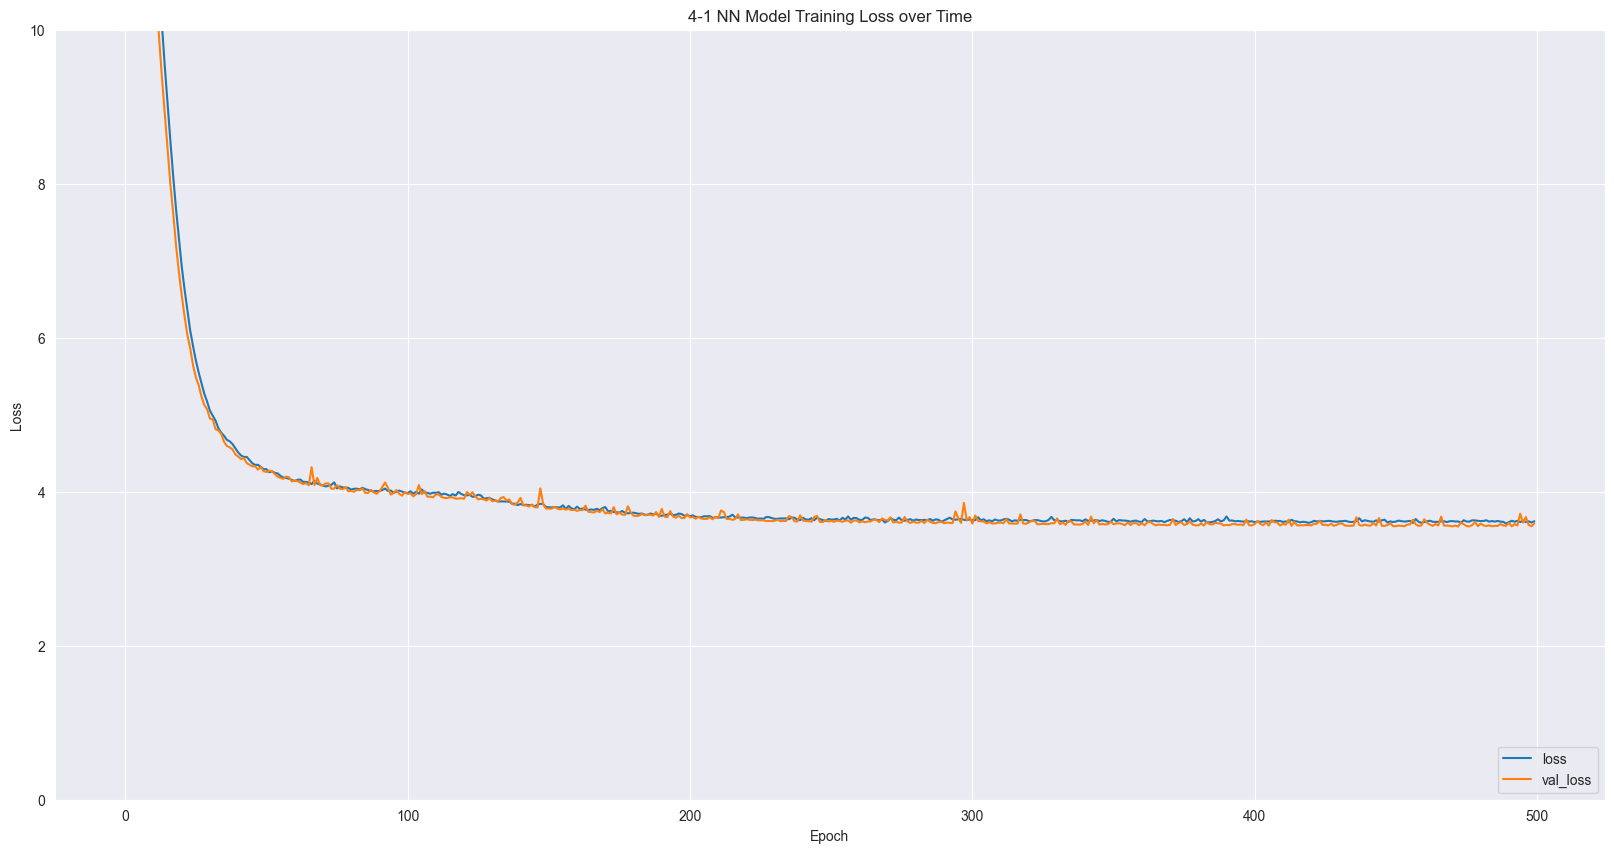

In [41]:
%%time
# reset the (4-1) model
all_models['4_1'] = keras.models.clone_model(all_models['4_1'])
all_models['4_1'].compile(**common_compile_options())

all_histories.update({'4_1':
    all_models['4_1'].fit(
        **common_fit_options,
        callbacks=[deep_4_checkpoint])})

plot_training_loss(all_histories['4_1'], '4-1 NN Model')


(4-1) Looks pretty good!

##### Neural Network Model (2-1)

CPU times: total: 8.61 s
Wall time: 35.6 s


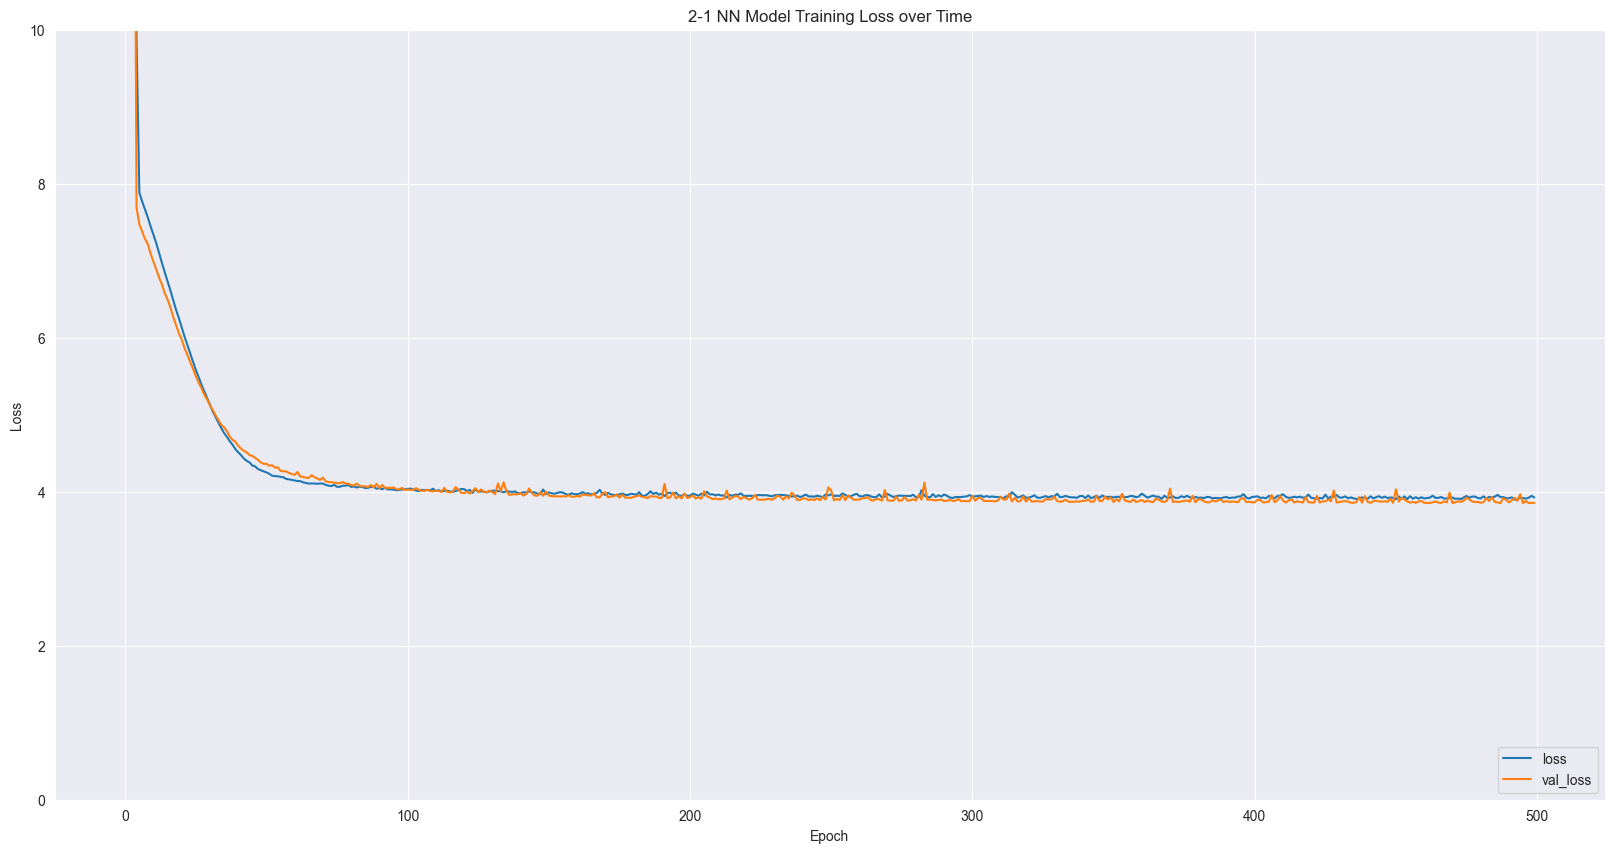

In [42]:
%%time
# reset the (2-1) model
all_models['2_1'] = keras.models.clone_model(all_models['2_1'])
all_models['2_1'].compile(**common_compile_options())

all_histories.update({'2_1':
    all_models['2_1'].fit(
        **common_fit_options,
        callbacks=[deep_2_checkpoint])})

plot_training_loss(all_histories['2_1'], '2-1 NN Model')


### Re-Plot Training Loss Over Time

Over 500 epochs, we can see how the models are learning.


CPU times: total: 31.2 ms
Wall time: 58.6 ms


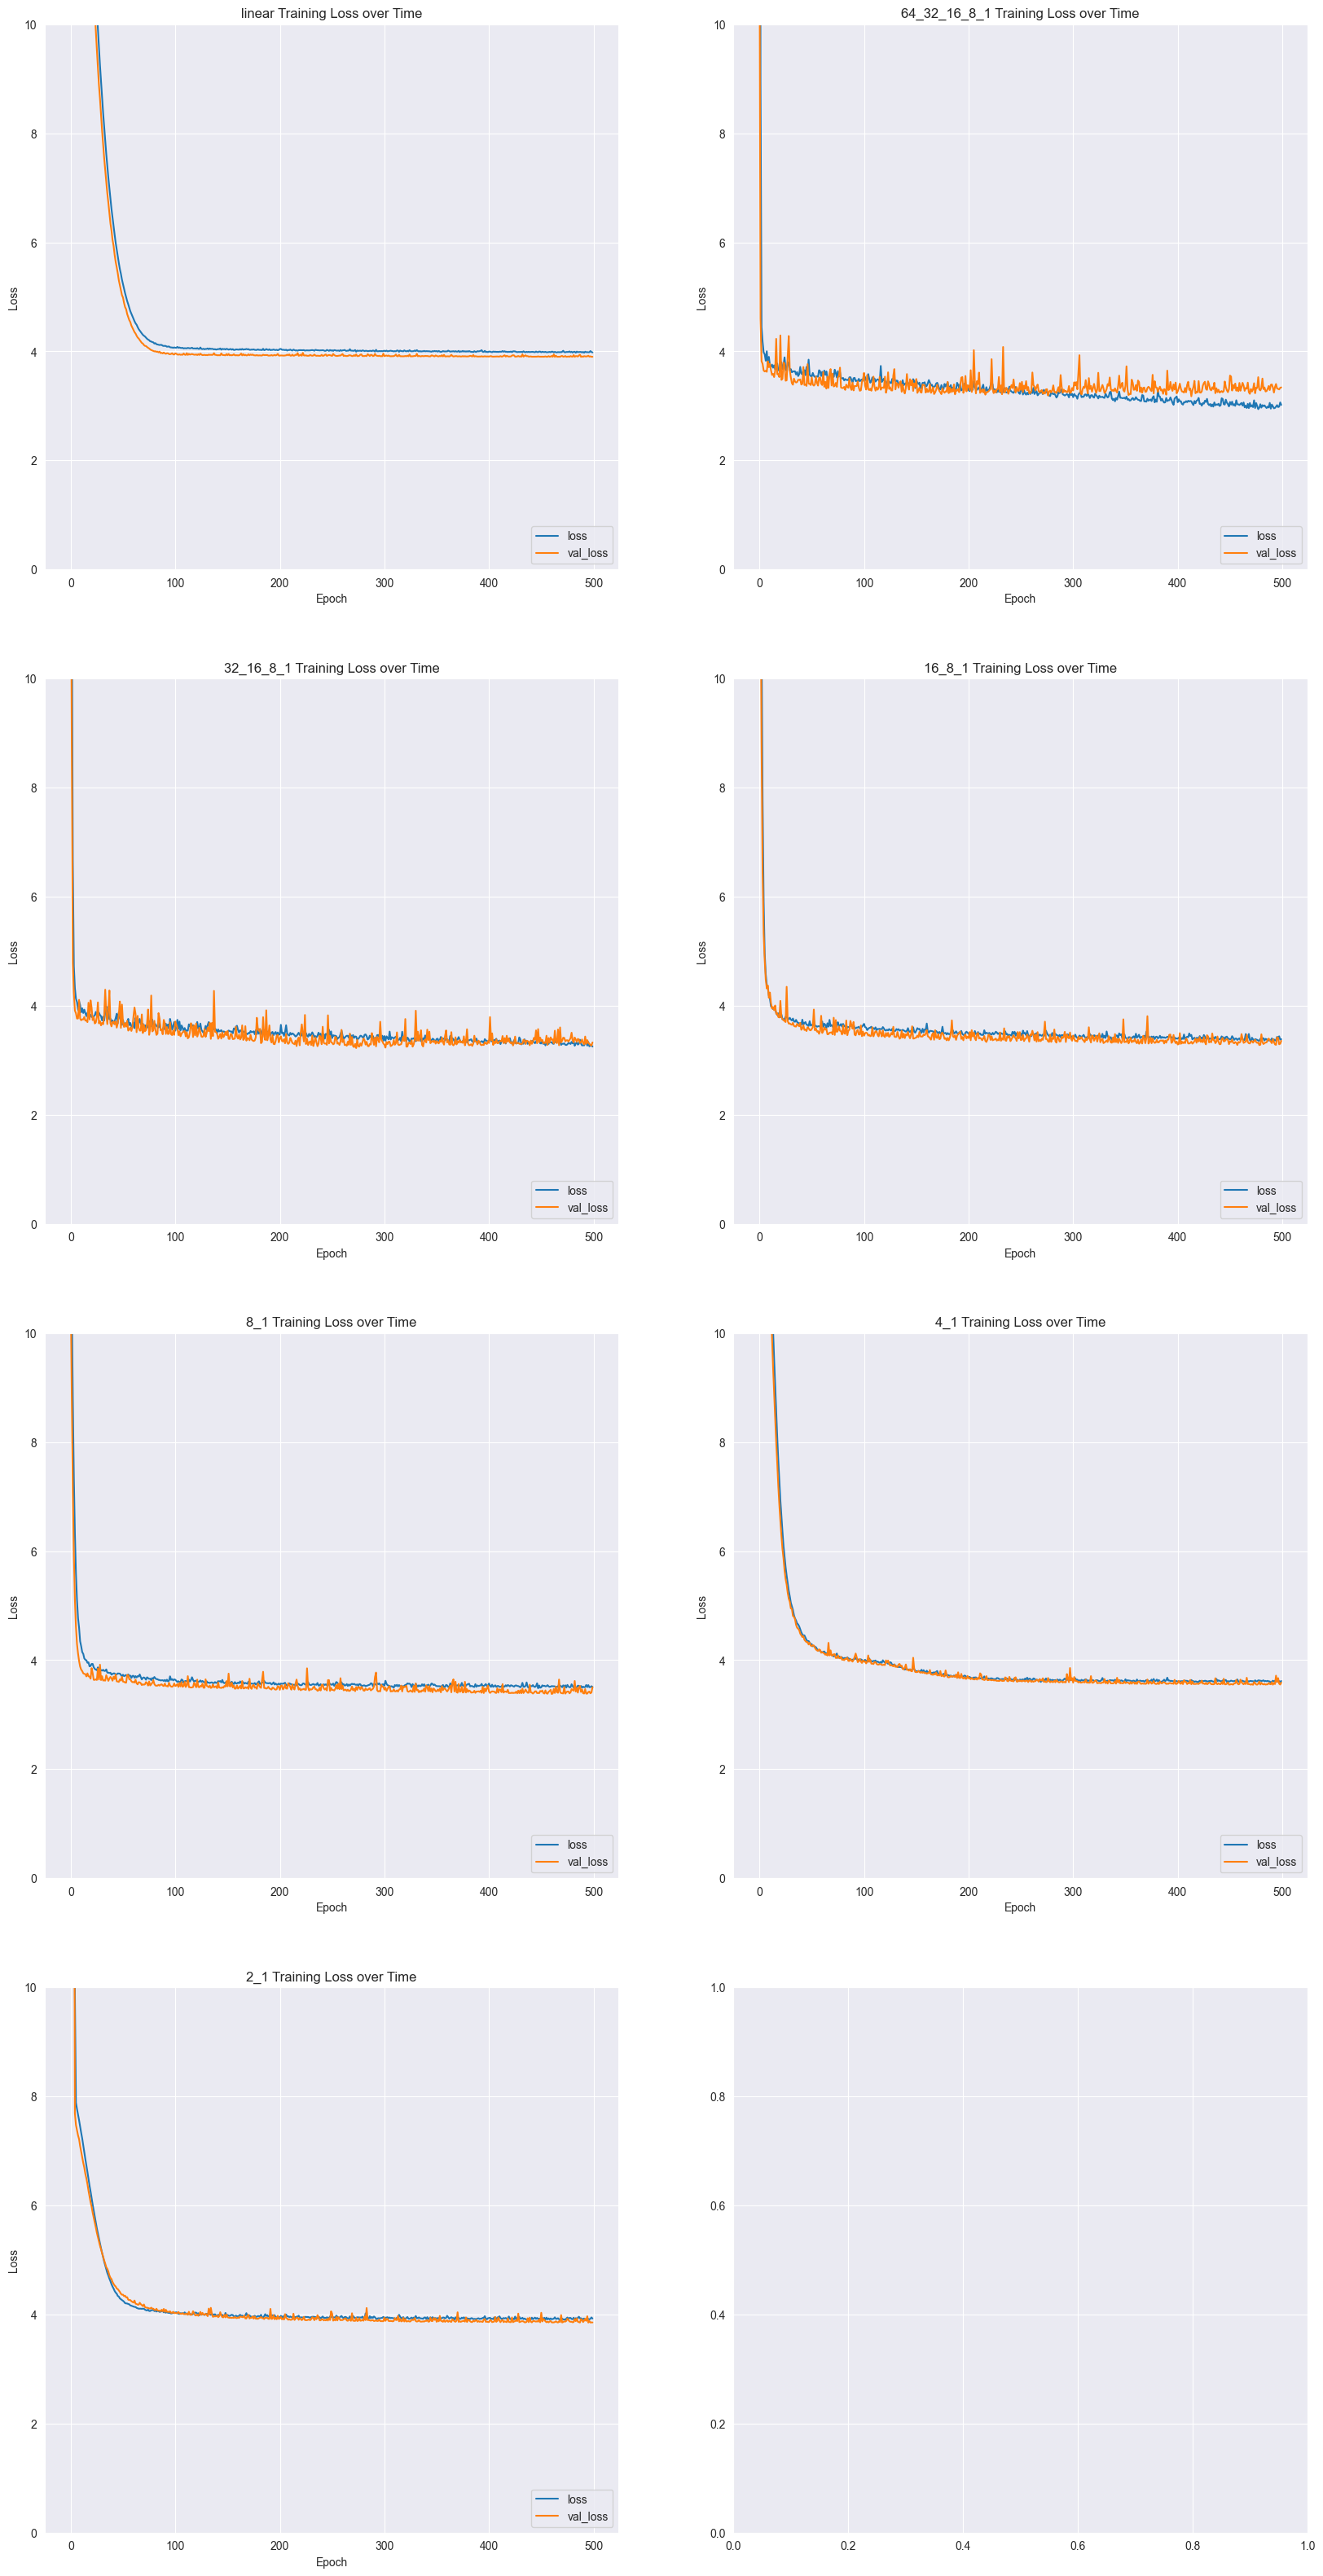

In [43]:
%%time
plot_training_loss_from_dict(all_histories)


#### Training Loss Over More Time Observations

Cool stuff!

##### Linear Model

- Finally showed up to the party.
- Shares a convergence with the (2-1) model to MSE of ~4.

##### Neural Network Model (64-32-16-8-1)

- Obviously overfitting.

##### Neural Network Model (32-16-8-1)

- Also overfitting.

##### Neural Network Model (16-8-1)
##### Neural Network Model (8-1)

- Similar to the more complex neural networks.
    - Less variance as the number of neurons decreases.

##### Neural Network Model (4-1)

- After a bumpy start, it got the hang of it.
    - Less variance in the training and validation loss. 

##### Neural Network Model (2-1)

- It never caught up.
- But it's not overfitting so much, so that's good.

***Note**: Implementing Early Stopping on these models resulted in early terminations in most cases.*


## Model Leaderboard

Let's re-score the models and see how they compare.

### My Criteria

- Mean Absolute Error within 2 years.
- Reasonable Explained Variance Score
- Reasonable R2 Score
- Avoid Overfitting
- Reasonable Learning Rate


In [44]:
%%time
# score each model
all_models = {
    'linear': all_models['linear'],
    '64_32_16_8_1': all_models['64_32_16_8_1'],
    '32_16_8_1': all_models['32_16_8_1'],
    '16_8_1': all_models['16_8_1'],
    '8_1': all_models['8_1'],
    '4_1': all_models['4_1'],
    '2_1': all_models['2_1']
}

# score on the test set
for model_name, model in all_models.items():
    preds = model.predict(X_test).flatten()
    scores_df = score_model(preds, np.array(y_test), index=model_name)
    leaderboard_df = score_combine(leaderboard_df, scores_df)

# copy untrained linear model scores - random doesn't get another chance here for time's sake
training_leaderboard_df = leaderboard_df.loc[['untrained_linear']]
# score on the training set
for model_name, model in all_models.items():
    preds = model.predict(X_train).flatten()
    scores_df = score_model(preds, np.array(y_train), index=model_name+'_train')
    training_leaderboard_df = score_combine(training_leaderboard_df, scores_df)

leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
CPU times: total: 594 ms
Wall time: 1.29 s


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,3.979310,1.477865,0.026506,0.026486
64_32_16_8_1,3.847977,1.453822,0.289476,0.279973
32_16_8_1,3.587128,1.400670,0.264803,0.263927
16_8_1,3.641958,1.377312,0.227436,0.213638
8_1,3.828832,1.410784,0.119383,0.098390
4_1,3.801162,1.462978,0.264745,0.254035
2_1,3.917418,1.476006,0.097723,0.097722


#### Test Set Leaderboard Observations

Everyone but the random model did pretty well. Let's see how they did on the training set.


In [45]:
%%time
training_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear_train,3.959852,1.484865,0.062017,0.061462
64_32_16_8_1_train,3.025558,1.290452,0.479924,0.470151
32_16_8_1_train,3.262485,1.328659,0.348704,0.348107
16_8_1_train,3.369894,1.314962,0.313775,0.302455
8_1_train,3.554512,1.345225,0.198247,0.181371
4_1_train,3.644263,1.424234,0.309046,0.297388
2_1_train,3.885171,1.472351,0.124076,0.123654


#### Training Set Leaderboard Observations



### Putting it All Together


In [46]:
%%time
combined_leaderboard_df = score_combine(leaderboard_df, training_leaderboard_df).sort_index()
combined_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 1.51 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
16_8_1,3.641958,1.377312,0.227436,0.213638
16_8_1_train,3.369894,1.314962,0.313775,0.302455
2_1,3.917418,1.476006,0.097723,0.097722
2_1_train,3.885171,1.472351,0.124076,0.123654
32_16_8_1,3.587128,1.400670,0.264803,0.263927
32_16_8_1_train,3.262485,1.328659,0.348704,0.348107
4_1,3.801162,1.462978,0.264745,0.254035
4_1_train,3.644263,1.424234,0.309046,0.297388
64_32_16_8_1,3.847977,1.453822,0.289476,0.279973
64_32_16_8_1_train,3.025558,1.290452,0.479924,0.470151


### Reminder of Our Metrics

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.


### Model Type Comparison

***Note**: Exclude the untrained linear model and MSE metric from these graphs for clarity.*


CPU times: total: 0 ns
Wall time: 34.6 ms


<Axes: title={'center': 'Feature-Rich vs Deep Learning Model Scores'}>

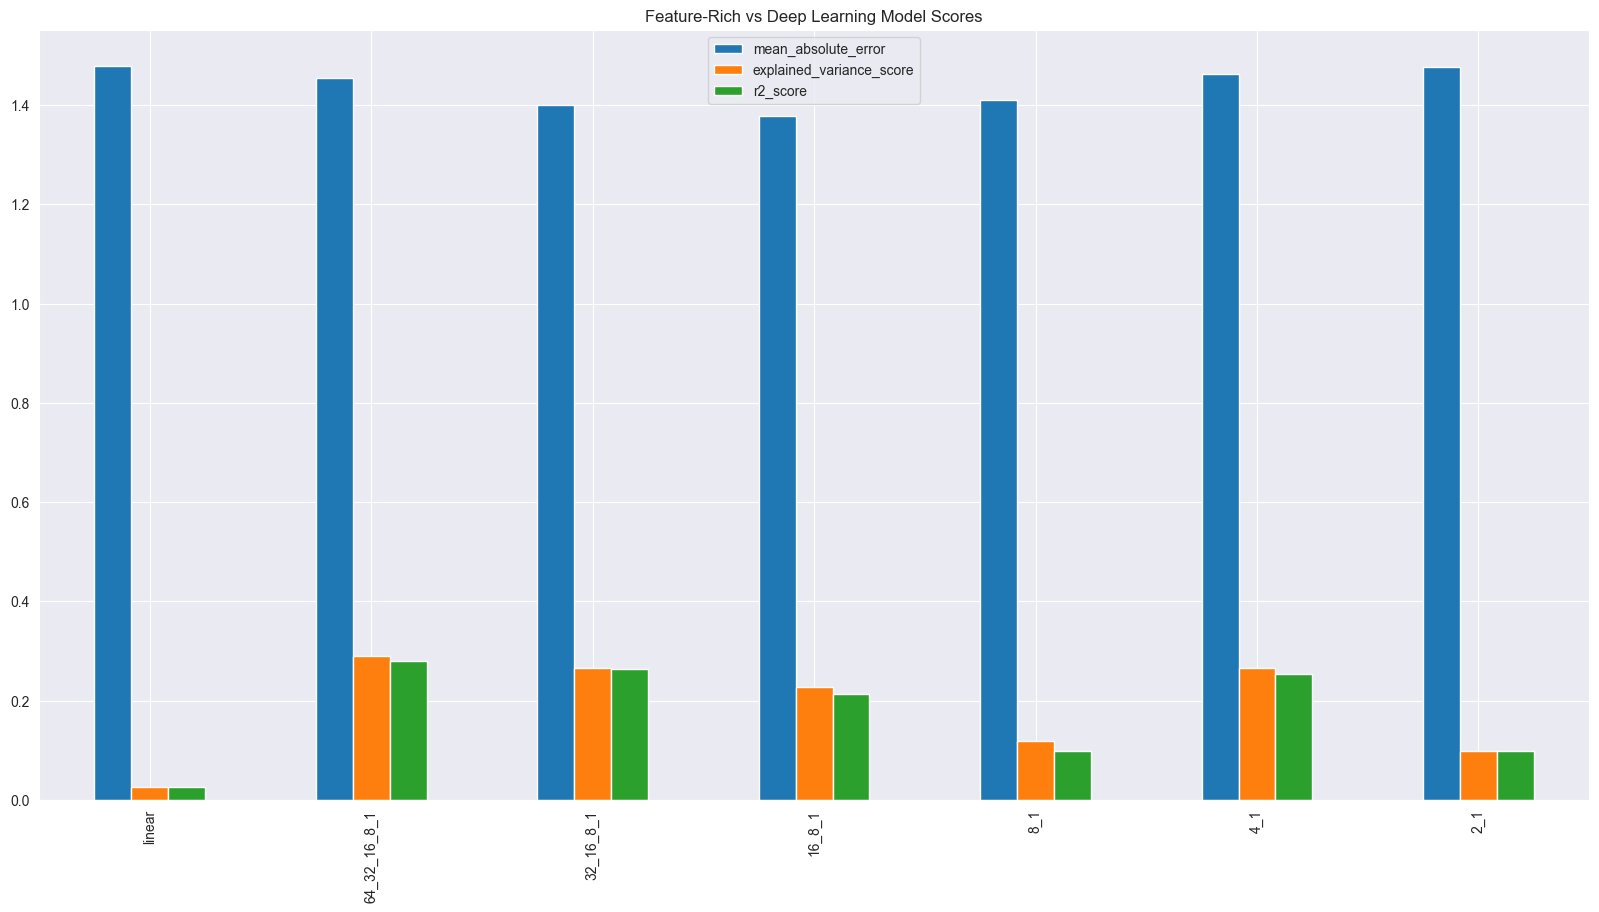

In [47]:
%%time
# exclude the untrained linear model, MSE from this graph for clarity
clarified_leaderboard_df = leaderboard_df.drop('untrained_linear').drop(['mean_squared_error'], axis=1)
clarified_leaderboard_df.plot(kind='bar', title='Feature-Rich vs Deep Learning Model Scores', figsize=(20, 10))


#### Score Comparison Observations

##### Neural Network Model (64-32-16-8-1)

(64-32-16-8-1) is definitely overfitting.

##### Neural Network Model (32-16-8-1)

(32-16-8-1) is overfitting.

##### Neural Network Model (16-8-1)

(16-8-1) is overfitting.

##### Neural Network Model (8-1)

(8-1) is not overfitting too much.

##### Neural Network Model (4-1)

(4-1) is not overfitting too much either.

##### Neural Network Model (2-1)

(2-1) is not overfitting too much either.


### Show the Leaderboard Again

In [48]:
%%time
leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear,3.979310,1.477865,0.026506,0.026486
64_32_16_8_1,3.847977,1.453822,0.289476,0.279973
32_16_8_1,3.587128,1.400670,0.264803,0.263927
16_8_1,3.641958,1.377312,0.227436,0.213638
8_1,3.828832,1.410784,0.119383,0.098390
4_1,3.801162,1.462978,0.264745,0.254035
2_1,3.917418,1.476006,0.097723,0.097722


#### On Training Data

Hopefully they did not do much better than their test counterparts.

In [49]:
%%time
training_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
untrained_linear,101.268135,9.740823,-1.322092,-35.831955
linear_train,3.959852,1.484865,0.062017,0.061462
64_32_16_8_1_train,3.025558,1.290452,0.479924,0.470151
32_16_8_1_train,3.262485,1.328659,0.348704,0.348107
16_8_1_train,3.369894,1.314962,0.313775,0.302455
8_1_train,3.554512,1.345225,0.198247,0.181371
4_1_train,3.644263,1.424234,0.309046,0.297388
2_1_train,3.885171,1.472351,0.124076,0.123654


#### Score These Scores

Why not?

These scores will show the level of similarity between the prediction on the test set vs. the training set.

This could be a good way to see if the model is overfitting or underfitting.


In [50]:
%%time
score_score_leaderboard_df = pd.DataFrame()

for model_name in leaderboard_df.index:
    if model_name == 'untrained_linear':
        continue
    score_score_leaderboard_df = score_combine(
        score_score_leaderboard_df,
        score_model(
            leaderboard_df.loc[[model_name]].transpose(),
            training_leaderboard_df.loc[[f'{model_name}_train']].transpose(), index=model_name
        )
    )

score_score_leaderboard_df[:]


CPU times: total: 15.6 ms
Wall time: 39 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
linear,0.000728,0.024236,0.999802,0.999721
64_32_16_8_1,0.193875,0.341604,0.919201,0.908385
32_16_8_1,0.031176,0.141184,0.984833,0.983059
16_8_1,0.023312,0.127393,0.988864,0.988052
8_1,0.023164,0.125431,0.990819,0.989960
4_1,0.007490,0.070824,0.996766,0.996418
2_1,0.000605,0.022047,0.999758,0.999751


## Choose the Best Architecture for the Job

Those pesky crabs don't want us to know how old they are. We'll find out soon enough.

First, let's choose the architecture to tune.

### My Criteria

- Mean Absolute Error within 2 years.
- Reasonable Explained Variance Score
- Reasonable R2 Score
- Avoid Overfitting
- Reasonable Learning Rate

Based on low MSE, high R2, and high Explained Variance, my choice is the (8-1) neural network architecture.

### Pursue the (8-1) Neural Network Architecture

Let's try some hyperparameter tuning on the (8-1) neural network model.

#### Why Not the (4-1) Neural Network Architecture?

Despite the (4-1) neural network model performing better over 500 epochs, it has some strange predictions in only 100 epochs.

In the interest of time and hyperparameter tuning, we'll stick with the (8-1) neural network model since it is good and faster to train to an acceptable level.


## Hyperparameter Tuning

Next, we will tune the hyperparameters of the (8-1) neural network model.

### Hyperparameters

- Optimizers (adam, nadam, rmsprop, sgd, adagrad, adadelta, adamax)
- Learning rates (0.1, 0.01, 0.001, 0.0001, etc.)
- Loss functions (mean_squared_error, mean_absolute_error, etc.)

##### Let's reset the number of epochs to the original value.

Save some time since not much progress was made with more epochs.


In [51]:
%%time
common_fit_options['epochs'] = 100


CPU times: total: 0 ns
Wall time: 0 ns


### Optimizer Tuning

Next we'll try compiling the (8-1) neural network model with different optimizers to look for any improvements.

We'll try the following optimizers:

- Adam
- Nadam
- RMSprop
- Stochoastic Gradient Descent (SGD)
- Adagrad
- Adadelta
- Adamax

#### Adam Optimizer

We have already been using the [Adam](https://keras.io/api/optimizers/adam/) optimizer, but let's try it again to get a baseline.

Adam is a popular optimizer that combines the best of Adagrad and RMSprop.

> Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
> According to [Kingma et al., 2014](http://arxiv.org/abs/1412.6980), the method is "computationally efficient, has little memory requirement,
> invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".


In [52]:
%%time
all_models['8_1_Adam'] = keras.models.clone_model(all_models['8_1'])

compile_options = common_compile_options()
compile_options['optimizer'] = keras.optimizers.Adam()

all_models['8_1_Adam'].compile(**compile_options)

deep_8_Adam_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_Adam.weights.h5'),
    **common_checkpoint_options)

# initialize history dictionary
optimizer_histories = {'8_1_Adam': \
    all_models['8_1_Adam'].fit(
        **common_fit_options,
        callbacks=[deep_8_Adam_checkpoint])}

all_models['8_1_Adam'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314 (1.23 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 196 (788.00 B)

CPU times: total: 1.69 s
Wall time: 7.93 s


##### Adam Optimizer Training Loss Plot

CPU times: total: 0 ns
Wall time: 7.51 ms


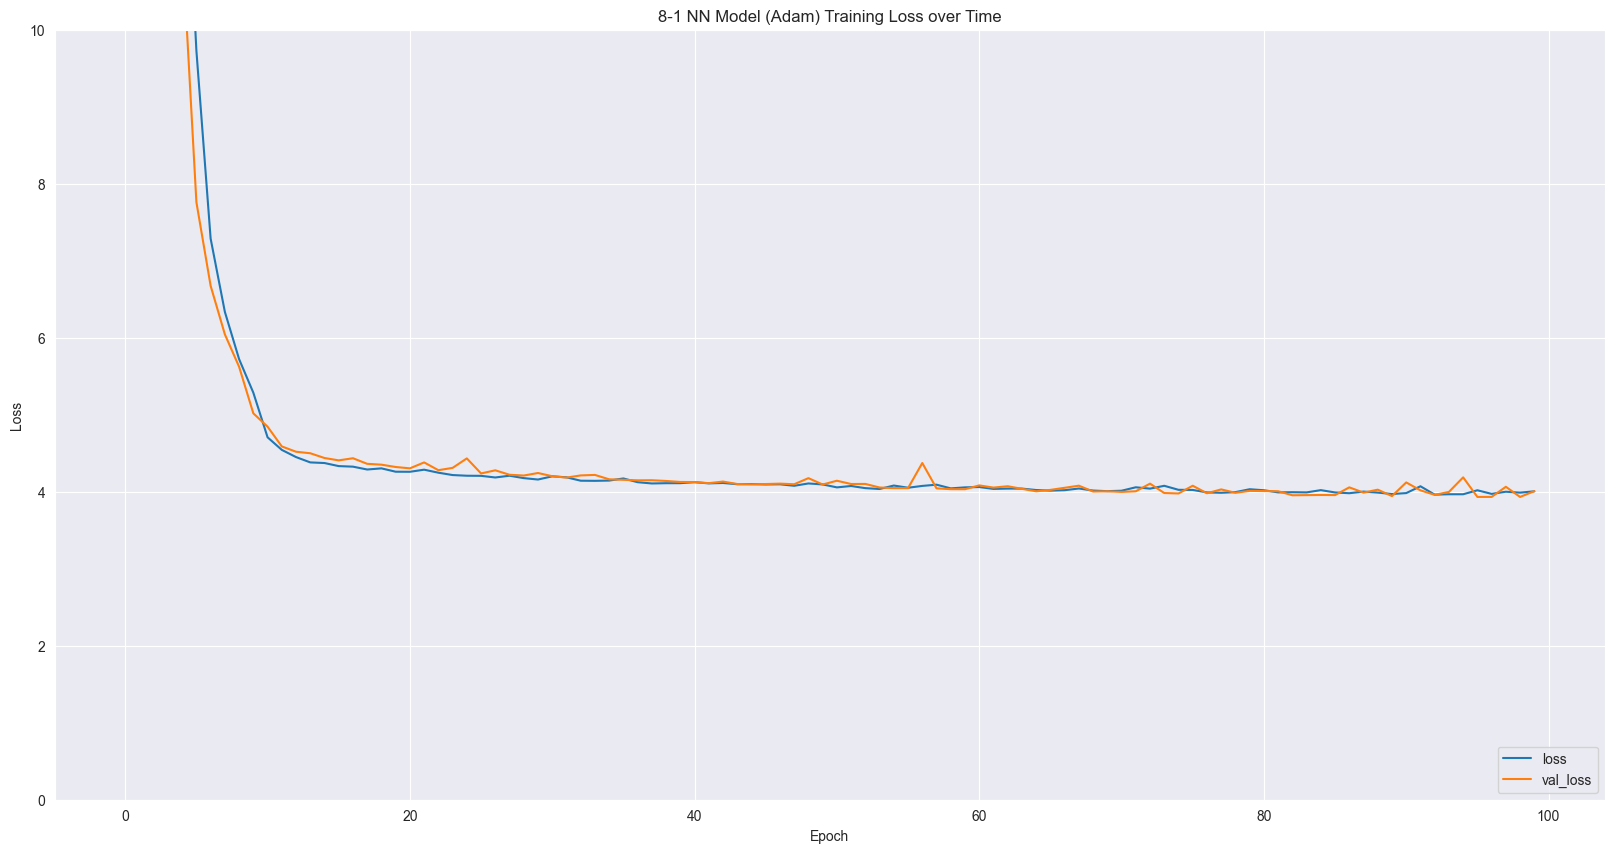

In [53]:
%%time
plot_training_loss(optimizer_histories['8_1_Adam'], '8-1 NN Model (Adam)')


##### Adam Optimizer Score

In [54]:
%%time
chosen_arch_preds = {} # initialize prediction dictionary
chosen_arch_preds.update({'8_1_Adam': all_models['8_1_Adam'].predict(X_test).flatten()})
deep_model_scores_df = score_model(chosen_arch_preds['8_1_Adam'], np.array(y_test), index='8_1_Adam')
# Add it to the leaderboard
optimizer_leaderboard_df = score_combine(pd.DataFrame(), deep_model_scores_df)
optimizer_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 0 ns
Wall time: 87.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497


#### Nadam Optimizer

[Nadam](https://keras.io/api/optimizers/Nadam/) is Adam with Nesterov momentum. It should converge faster than Adam by incorporating a look-ahead feature.


In [55]:
%%time
all_models['8_1_Nadam'] = keras.models.clone_model(all_models['8_1'])

compile_options = common_compile_options()
compile_options['optimizer'] = keras.optimizers.Nadam()

all_models['8_1_Nadam'].compile(**compile_options)

deep_8_Nadam_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_Nadam.weights.h5'),
    **common_checkpoint_options)

optimizer_histories['8_1_Nadam'] = \
    all_models['8_1_Nadam'].fit(
        **common_fit_options,
        callbacks=[deep_8_Nadam_checkpoint])

all_models['8_1_Nadam'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.24 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 197 (792.00 B)

CPU times: total: 1.78 s
Wall time: 8.42 s


##### Nadam Optimizer Training Loss Plot

It does seem to converge slightly faster than Adam.


CPU times: total: 0 ns
Wall time: 7.51 ms


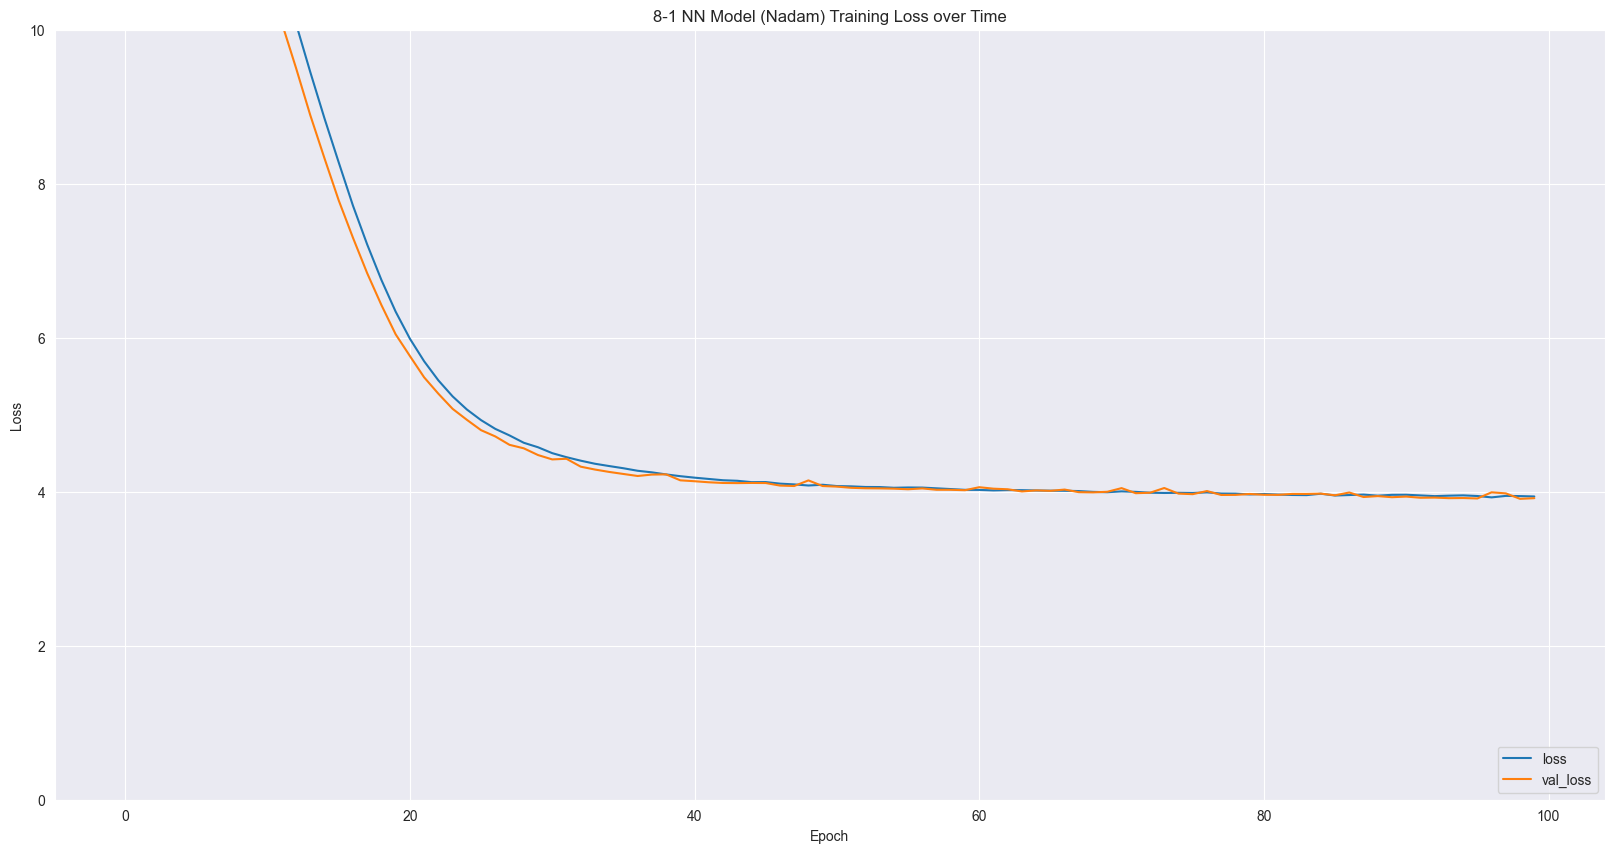

In [56]:
%%time
plot_training_loss(optimizer_histories['8_1_Nadam'], '8-1 NN Model (Nadam)')


##### Nadam Optimizer Score

In [57]:
%%time
chosen_arch_preds.update({'8_1_Nadam': all_models['8_1_Nadam'].predict(X_test).flatten()})
deep_model_scores_df = score_model(chosen_arch_preds['8_1_Nadam'], np.array(y_test), index='8_1_Nadam')
# Add it to the leaderboard
optimizer_leaderboard_df = score_combine(optimizer_leaderboard_df, deep_model_scores_df)
optimizer_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 31.2 ms
Wall time: 101 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497
8_1_Nadam,3.965157,1.461784,0.021186,0.018805


#### RMSprop Optimizer

[RMSprop](https://keras.io/api/optimizers/rmsprop/) is a good choice for recurrent neural networks. It's similar to Adagrad, but it uses a moving average of the squared gradient for normalization.

In [58]:
%%time
all_models['8_1_RMSprop'] = keras.models.clone_model(all_models['8_1'])

compile_options = common_compile_options()
compile_options['optimizer'] = keras.optimizers.RMSprop()

all_models['8_1_RMSprop'].compile(**compile_options)

deep_8_RMSprop_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_RMSprop.weights.h5'),
    **common_checkpoint_options)

optimizer_histories['8_1_RMSprop'] = \
    all_models['8_1_RMSprop'].fit(
        **common_fit_options,
        callbacks=[deep_8_RMSprop_checkpoint])

all_models['8_1_RMSprop'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217 (876.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 99 (400.00 B)

CPU times: total: 578 ms
Wall time: 7.48 s


##### RMSprop Optimizer Training Loss Plot

CPU times: total: 0 ns
Wall time: 8 ms


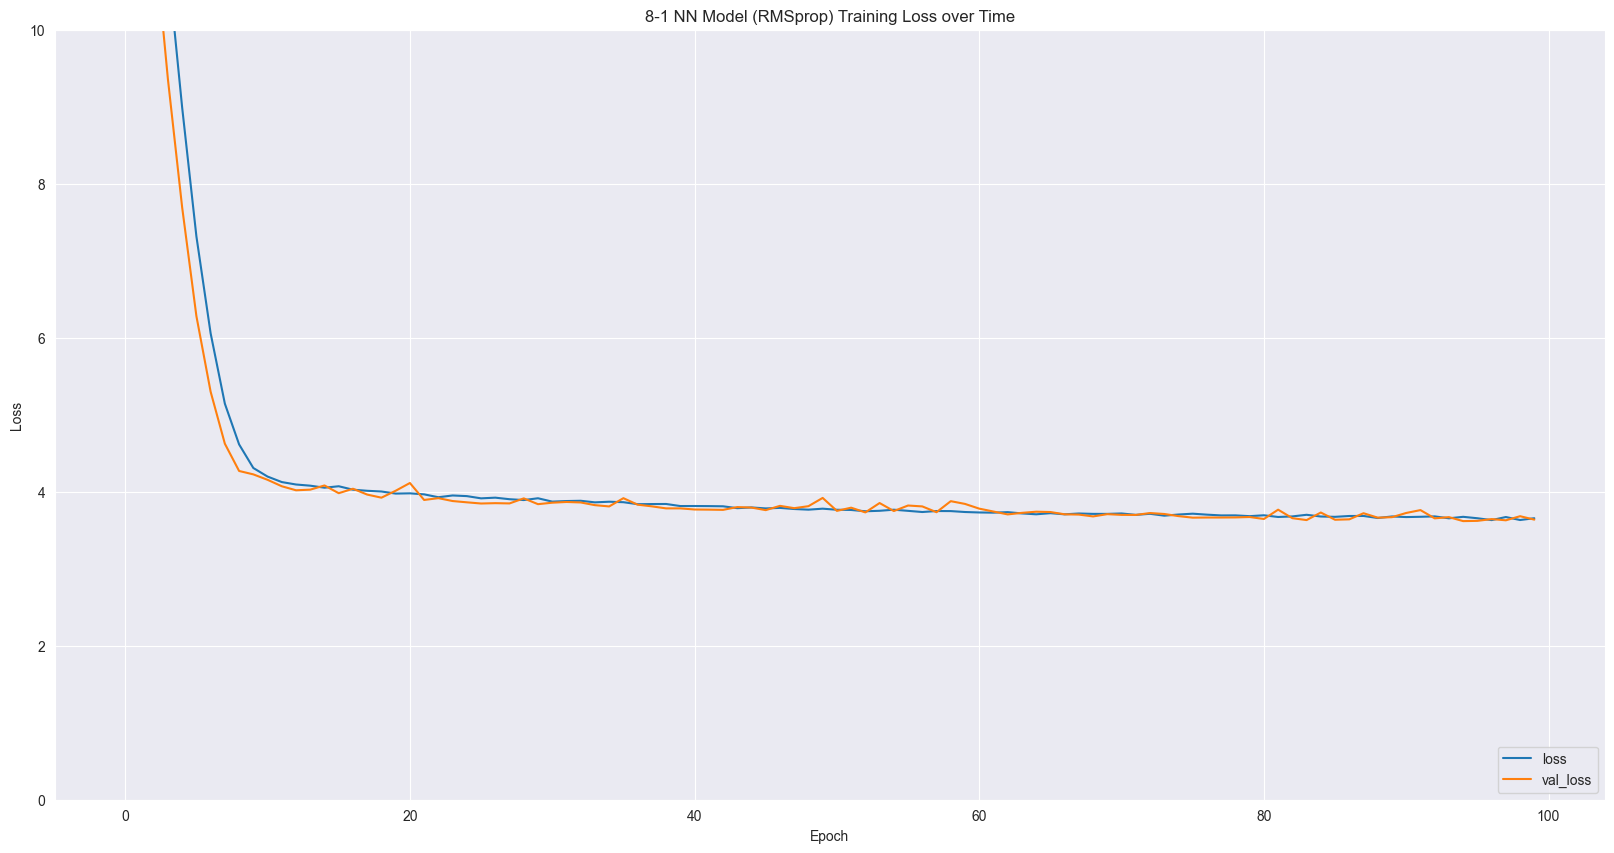

In [59]:
%%time
plot_training_loss(optimizer_histories['8_1_RMSprop'], '8-1 NN Model (RMSprop)')


##### RMSprop Optimizer Score

In [60]:
%%time
chosen_arch_preds.update({'8_1_RMSprop': all_models['8_1_RMSprop'].predict(X_test).flatten()})
deep_model_scores_df = score_model(chosen_arch_preds['8_1_RMSprop'], np.array(y_test), index='8_1_RMSprop')
# Add it to the leaderboard
optimizer_leaderboard_df = score_combine(optimizer_leaderboard_df, deep_model_scores_df)
optimizer_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 31.2 ms
Wall time: 88.6 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497
8_1_Nadam,3.965157,1.461784,0.021186,0.018805
8_1_RMSprop,3.789742,1.430566,0.178975,0.178922


#### Stochastic Gradient Descent (SGD) Optimizer

[SGD](https://keras.io/api/optimizers/sgd/) is the classic optimizer. It's a good choice for shallow networks or small datasets.

In [61]:
%%time
all_models['8_1_SGD'] = keras.models.clone_model(all_models['8_1'])

compile_options = common_compile_options()
compile_options['optimizer'] = keras.optimizers.SGD()

all_models['8_1_SGD'].compile(**compile_options)

deep_8_SGD_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_SGD.weights.h5'),
    **common_checkpoint_options)

optimizer_histories['8_1_SGD'] = \
    all_models['8_1_SGD'].fit(
        **common_fit_options,
        callbacks=[deep_8_SGD_checkpoint])

all_models['8_1_SGD'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120 (488.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 2 (12.00 B)

CPU times: total: 609 ms
Wall time: 7.42 s


##### SGD Optimizer Training Loss Plot

CPU times: total: 0 ns
Wall time: 7 ms


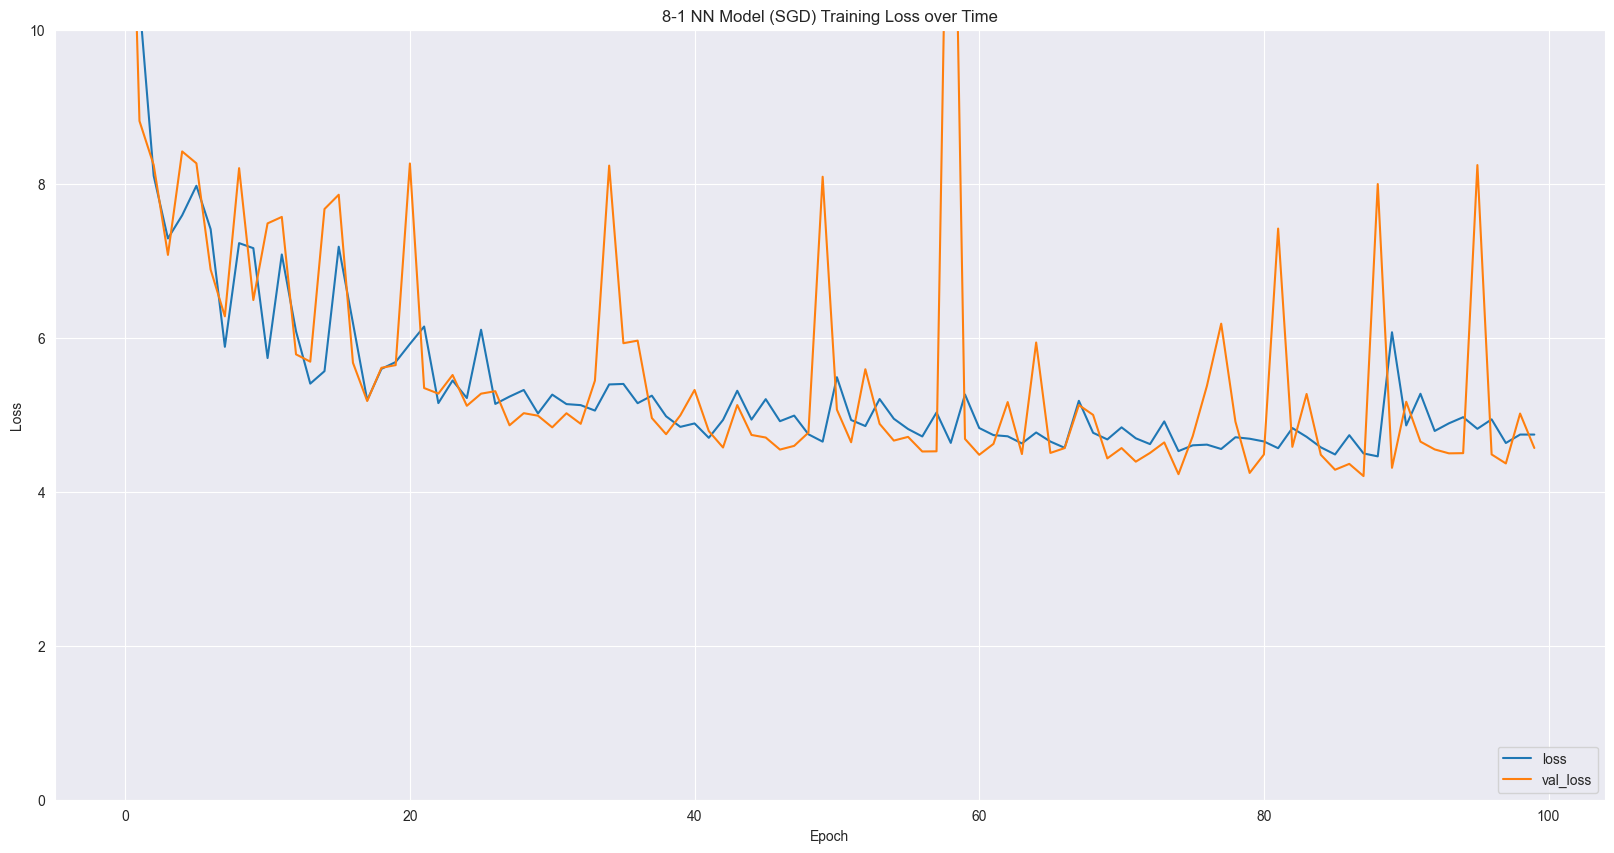

In [62]:
%%time
plot_training_loss(optimizer_histories['8_1_SGD'], '8-1 NN Model (SGD)')


##### SGD Optimizer Score

That training loss is crazy. Hopefully the test scores are better.


In [63]:
%%time
chosen_arch_preds.update({'8_1_SGD': all_models['8_1_SGD'].predict(X_test).flatten()})
deep_model_scores_df = score_model(chosen_arch_preds['8_1_SGD'], np.array(y_test), index='8_1_SGD')
# Add it to the leaderboard
optimizer_leaderboard_df = score_combine(optimizer_leaderboard_df, deep_model_scores_df)
optimizer_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 31.2 ms
Wall time: 88.3 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497
8_1_Nadam,3.965157,1.461784,0.021186,0.018805
8_1_RMSprop,3.789742,1.430566,0.178975,0.178922
8_1_SGD,4.426535,1.589397,-0.444427,-0.453964


#### Adagrad Optimizer

[Adagrad](https://keras.io/api/optimizers/adagrad/) is a good choice for sparse data. It adapts the learning rate based on the frequency of features.

In [64]:
%%time
all_models['8_1_Adagrad'] = keras.models.clone_model(all_models['8_1'])

compile_options = common_compile_options()
compile_options['optimizer'] = keras.optimizers.Adagrad()

all_models['8_1_Adagrad'].compile(**compile_options)

deep_8_Adagrad_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_Adagrad.weights.h5'),
    **common_checkpoint_options)

optimizer_histories['8_1_Adagrad'] = \
    all_models['8_1_Adagrad'].fit(
        **common_fit_options,
        callbacks=[deep_8_Adagrad_checkpoint])

all_models['8_1_Adagrad'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217 (876.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 99 (400.00 B)

CPU times: total: 375 ms
Wall time: 7.73 s


##### Adagrad Optimizer Training Loss Plot

CPU times: total: 0 ns
Wall time: 7.51 ms


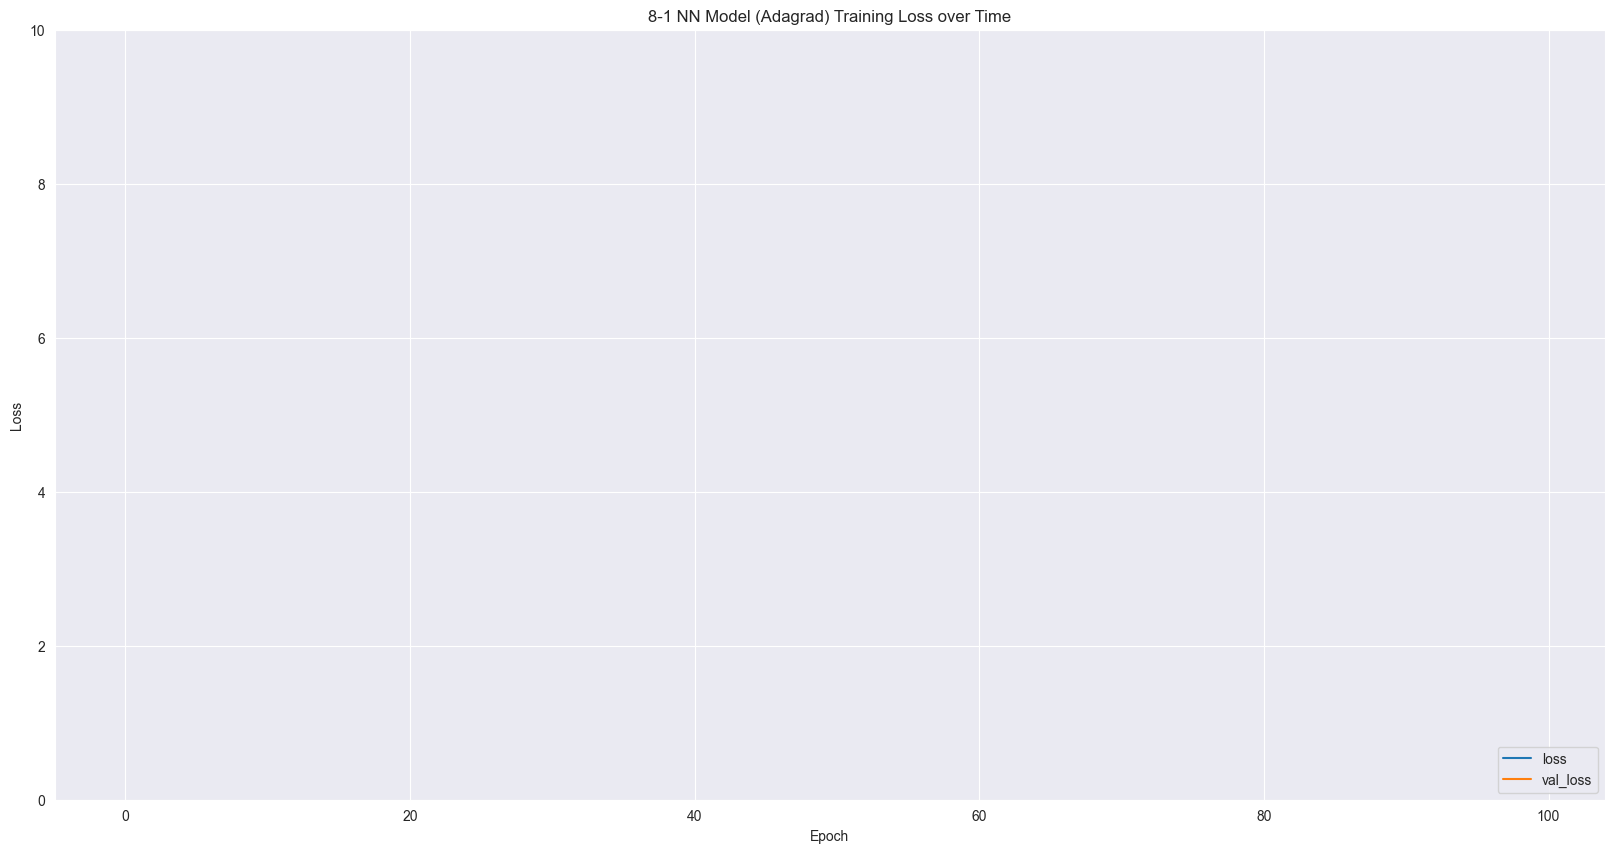

In [65]:
%%time
plot_training_loss(optimizer_histories['8_1_Adagrad'], '8-1 NN Model (Adagrad)')


##### Adagrad Optimizer Score

Is it just me, or did Adagrad not learn anything yet?

In [66]:
%%time
chosen_arch_preds.update({'8_1_Adagrad': all_models['8_1_Adagrad'].predict(X_test).flatten()})
deep_model_scores_df = score_model(chosen_arch_preds['8_1_Adagrad'], np.array(y_test), index='8_1_Adagrad')
# Add it to the leaderboard
optimizer_leaderboard_df = score_combine(optimizer_leaderboard_df, deep_model_scores_df)
optimizer_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 90.9 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497
8_1_Nadam,3.965157,1.461784,0.021186,0.018805
8_1_RMSprop,3.789742,1.430566,0.178975,0.178922
8_1_SGD,4.426535,1.589397,-0.444427,-0.453964
8_1_Adagrad,11.848803,2.711921,0.338343,0.246368


#### Adadelta Optimizer

[Adadelta](https://keras.io/api/optimizers/adadelta/) is a good choice for large datasets.

> Adadelta optimization is a stochastic gradient descent method that is based on adaptive learning rate per dimension to address two drawbacks:
> - The continual decay of learning rates throughout training.
> - The need for a manually selected global learning rate.


If its namesake is any indication, it might not do so well here. We'll see.


In [67]:
%%time
all_models['8_1_Adadelta'] = keras.models.clone_model(all_models['8_1'])

compile_options = common_compile_options()
compile_options['optimizer'] = keras.optimizers.Adadelta()

all_models['8_1_Adadelta'].compile(**compile_options)

deep_8_Adadelta_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_Adadelta.weights.h5'),
    **common_checkpoint_options)

optimizer_histories['8_1_Adadelta'] = \
    all_models['8_1_Adadelta'].fit(
        **common_fit_options,
        callbacks=[deep_8_Adadelta_checkpoint])

all_models['8_1_Adadelta'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314 (1.23 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 196 (788.00 B)

CPU times: total: 1.42 s
Wall time: 8.51 s


##### Adadelta Optimizer Training Loss Plot

CPU times: total: 0 ns
Wall time: 8.51 ms


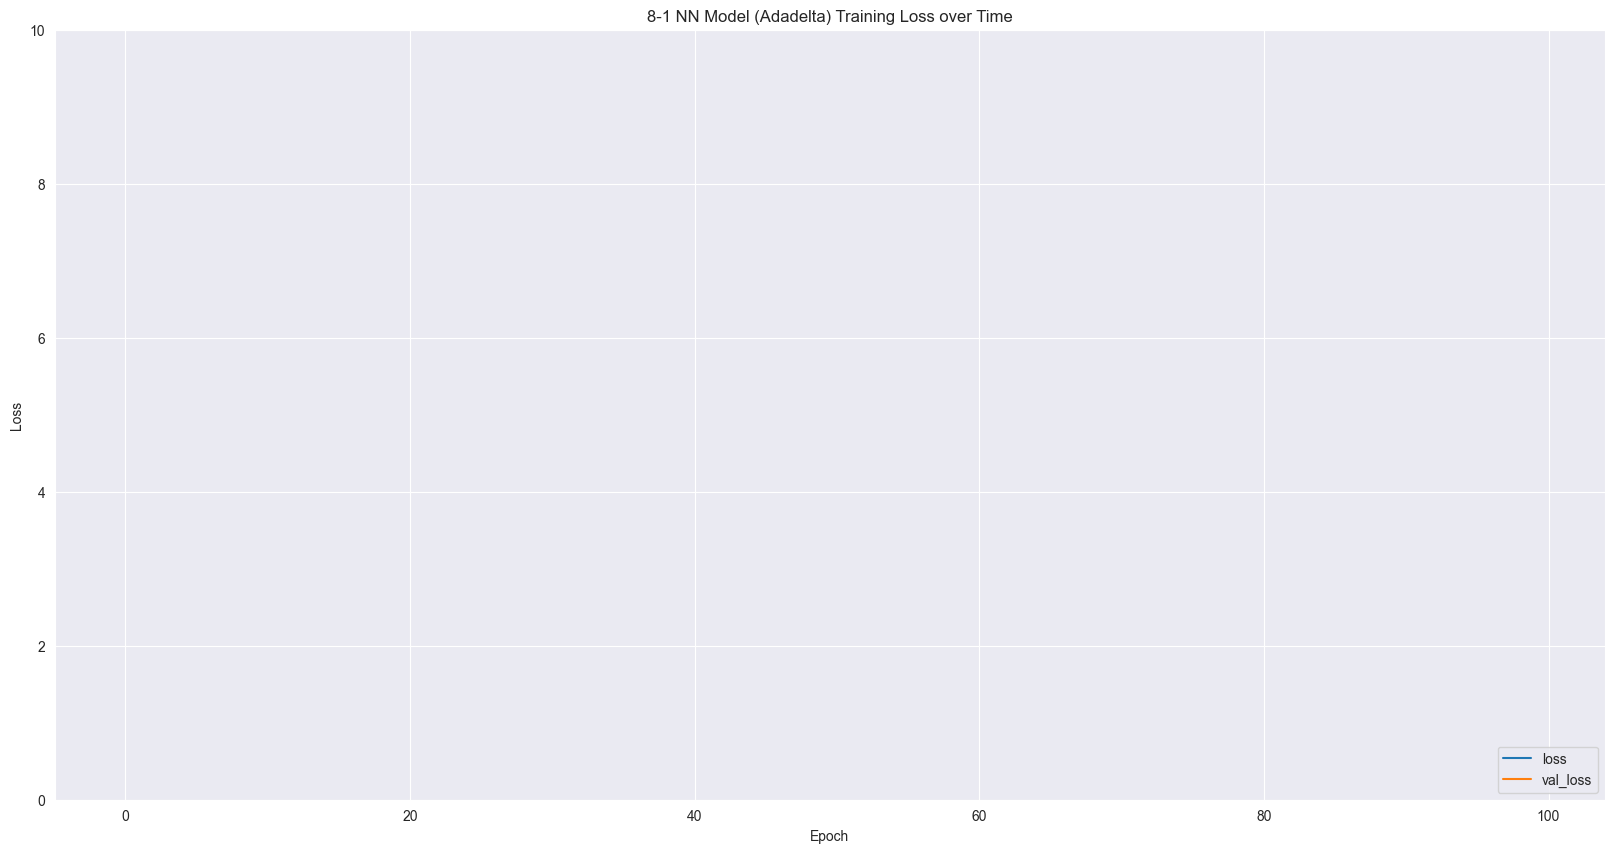

In [68]:
%%time
plot_training_loss(optimizer_histories['8_1_Adadelta'], '8-1 NN Model (Adadelta)')


##### Adadelta Optimizer Score

It's not looking good for Adadelta based on the training loss plot.

Maybe the scores will redeem it?


In [69]:
%%time
chosen_arch_preds.update({'8_1_Adadelta': all_models['8_1_Adadelta'].predict(X_test).flatten()})
deep_model_scores_df = score_model(chosen_arch_preds['8_1_Adadelta'], np.array(y_test), index='8_1_Adadelta')
# Add it to the leaderboard
optimizer_leaderboard_df = score_combine(optimizer_leaderboard_df, deep_model_scores_df)
optimizer_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 15.6 ms
Wall time: 90.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497
8_1_Nadam,3.965157,1.461784,0.021186,0.018805
8_1_RMSprop,3.789742,1.430566,0.178975,0.178922
8_1_SGD,4.426535,1.589397,-0.444427,-0.453964
8_1_Adagrad,11.848803,2.711921,0.338343,0.246368
8_1_Adadelta,41.268192,5.898095,-0.069903,-5.753660


#### Adamax Optimizer

[Adamax](https://keras.io/api/optimizers/adamax/) is a variant of Adam based on infinity norm.

It is suited for time-variant processes, so it might not be the best choice here. Let's try it anyway.

In [70]:
%%time
all_models['8_1_Adamax'] = keras.models.clone_model(all_models['8_1'])

compile_options = common_compile_options()
compile_options['optimizer'] = keras.optimizers.Adamax()

all_models['8_1_Adamax'].compile(**compile_options)

deep_8_Adamax_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_Adamax.weights.h5'),
    **common_checkpoint_options)

optimizer_histories['8_1_Adamax'] = \
    all_models['8_1_Adamax'].fit(
        **common_fit_options,
        callbacks=[deep_8_Adamax_checkpoint])

all_models['8_1_Adamax'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314 (1.23 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 196 (788.00 B)

CPU times: total: 875 ms
Wall time: 8.05 s


##### Adamax Optimizer Training Loss Plot

CPU times: total: 0 ns
Wall time: 9.51 ms


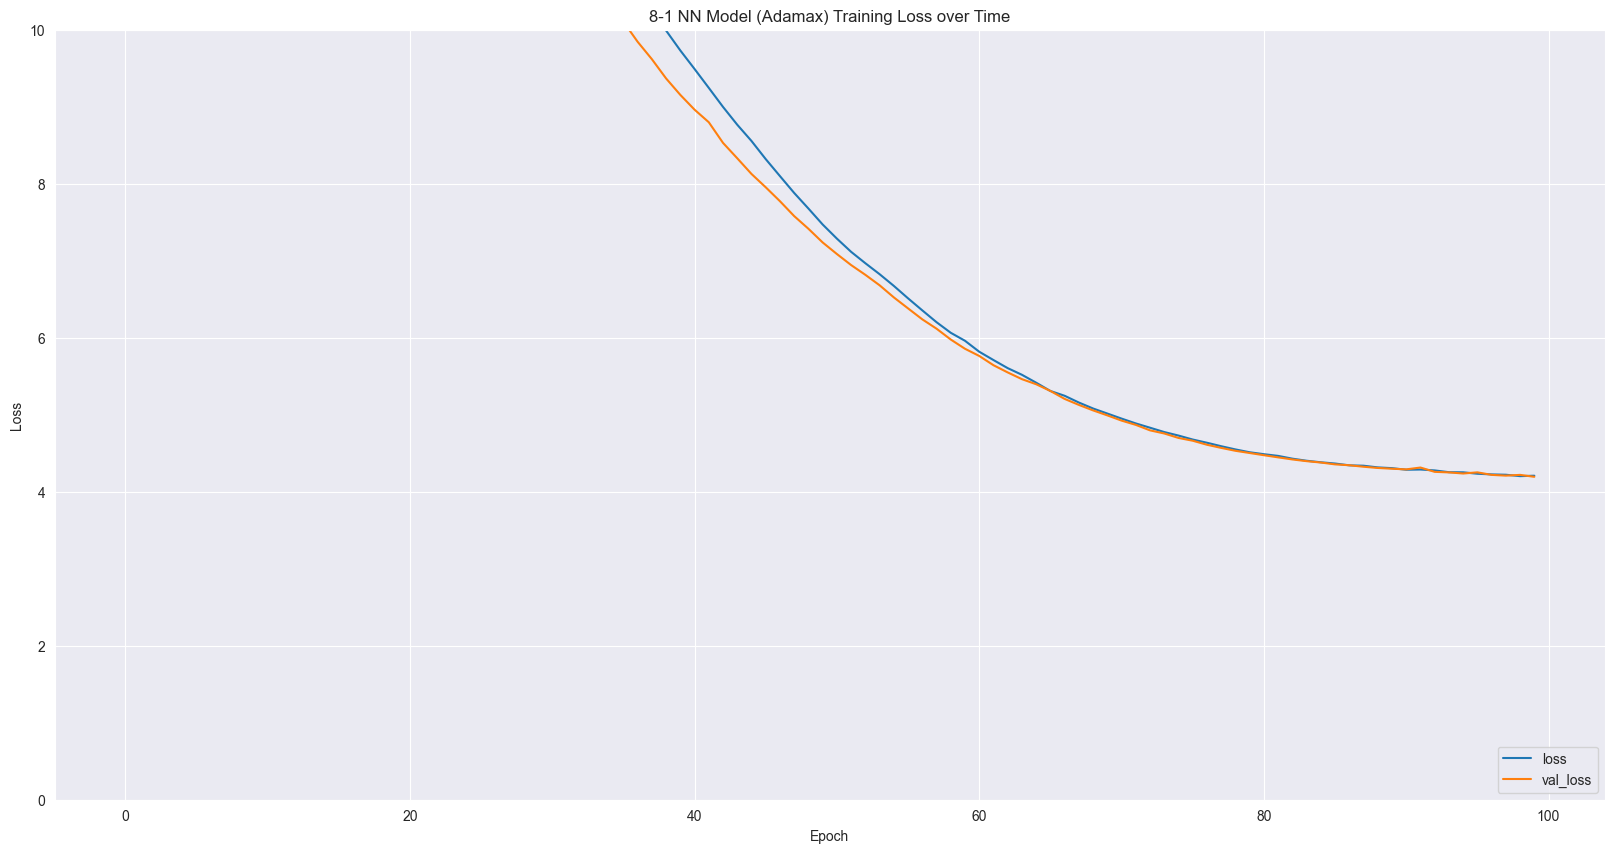

In [71]:
%%time
plot_training_loss(optimizer_histories['8_1_Adamax'], '8-1 NN Model (Adamax)')


##### Adamax Optimizer Score

It held up pretty well despite our initial doubts.


In [72]:
%%time
chosen_arch_preds.update({'8_1_Adamax': all_models['8_1_Adamax'].predict(X_test).flatten()})
deep_model_scores_df = score_model(chosen_arch_preds['8_1_Adamax'], np.array(y_test), index='8_1_Adamax')
# Add it to the leaderboard
optimizer_leaderboard_df = score_combine(optimizer_leaderboard_df, deep_model_scores_df)
optimizer_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 62.5 ms
Wall time: 94 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497
8_1_Nadam,3.965157,1.461784,0.021186,0.018805
8_1_RMSprop,3.789742,1.430566,0.178975,0.178922
8_1_SGD,4.426535,1.589397,-0.444427,-0.453964
8_1_Adagrad,11.848803,2.711921,0.338343,0.246368
8_1_Adadelta,41.268192,5.898095,-0.069903,-5.753660
8_1_Adamax,4.259034,1.536539,-0.064128,-0.064187


### Optimizer Decision

The results are in! Time to choose an optimizer.

We'll take the best optimizer and move on to tuning the next hyperparameter, learning rate.

#### Optimizer Training Loss Plots

Let's look at the big picture by looking at all the training loss plots.


CPU times: total: 46.9 ms
Wall time: 56.1 ms


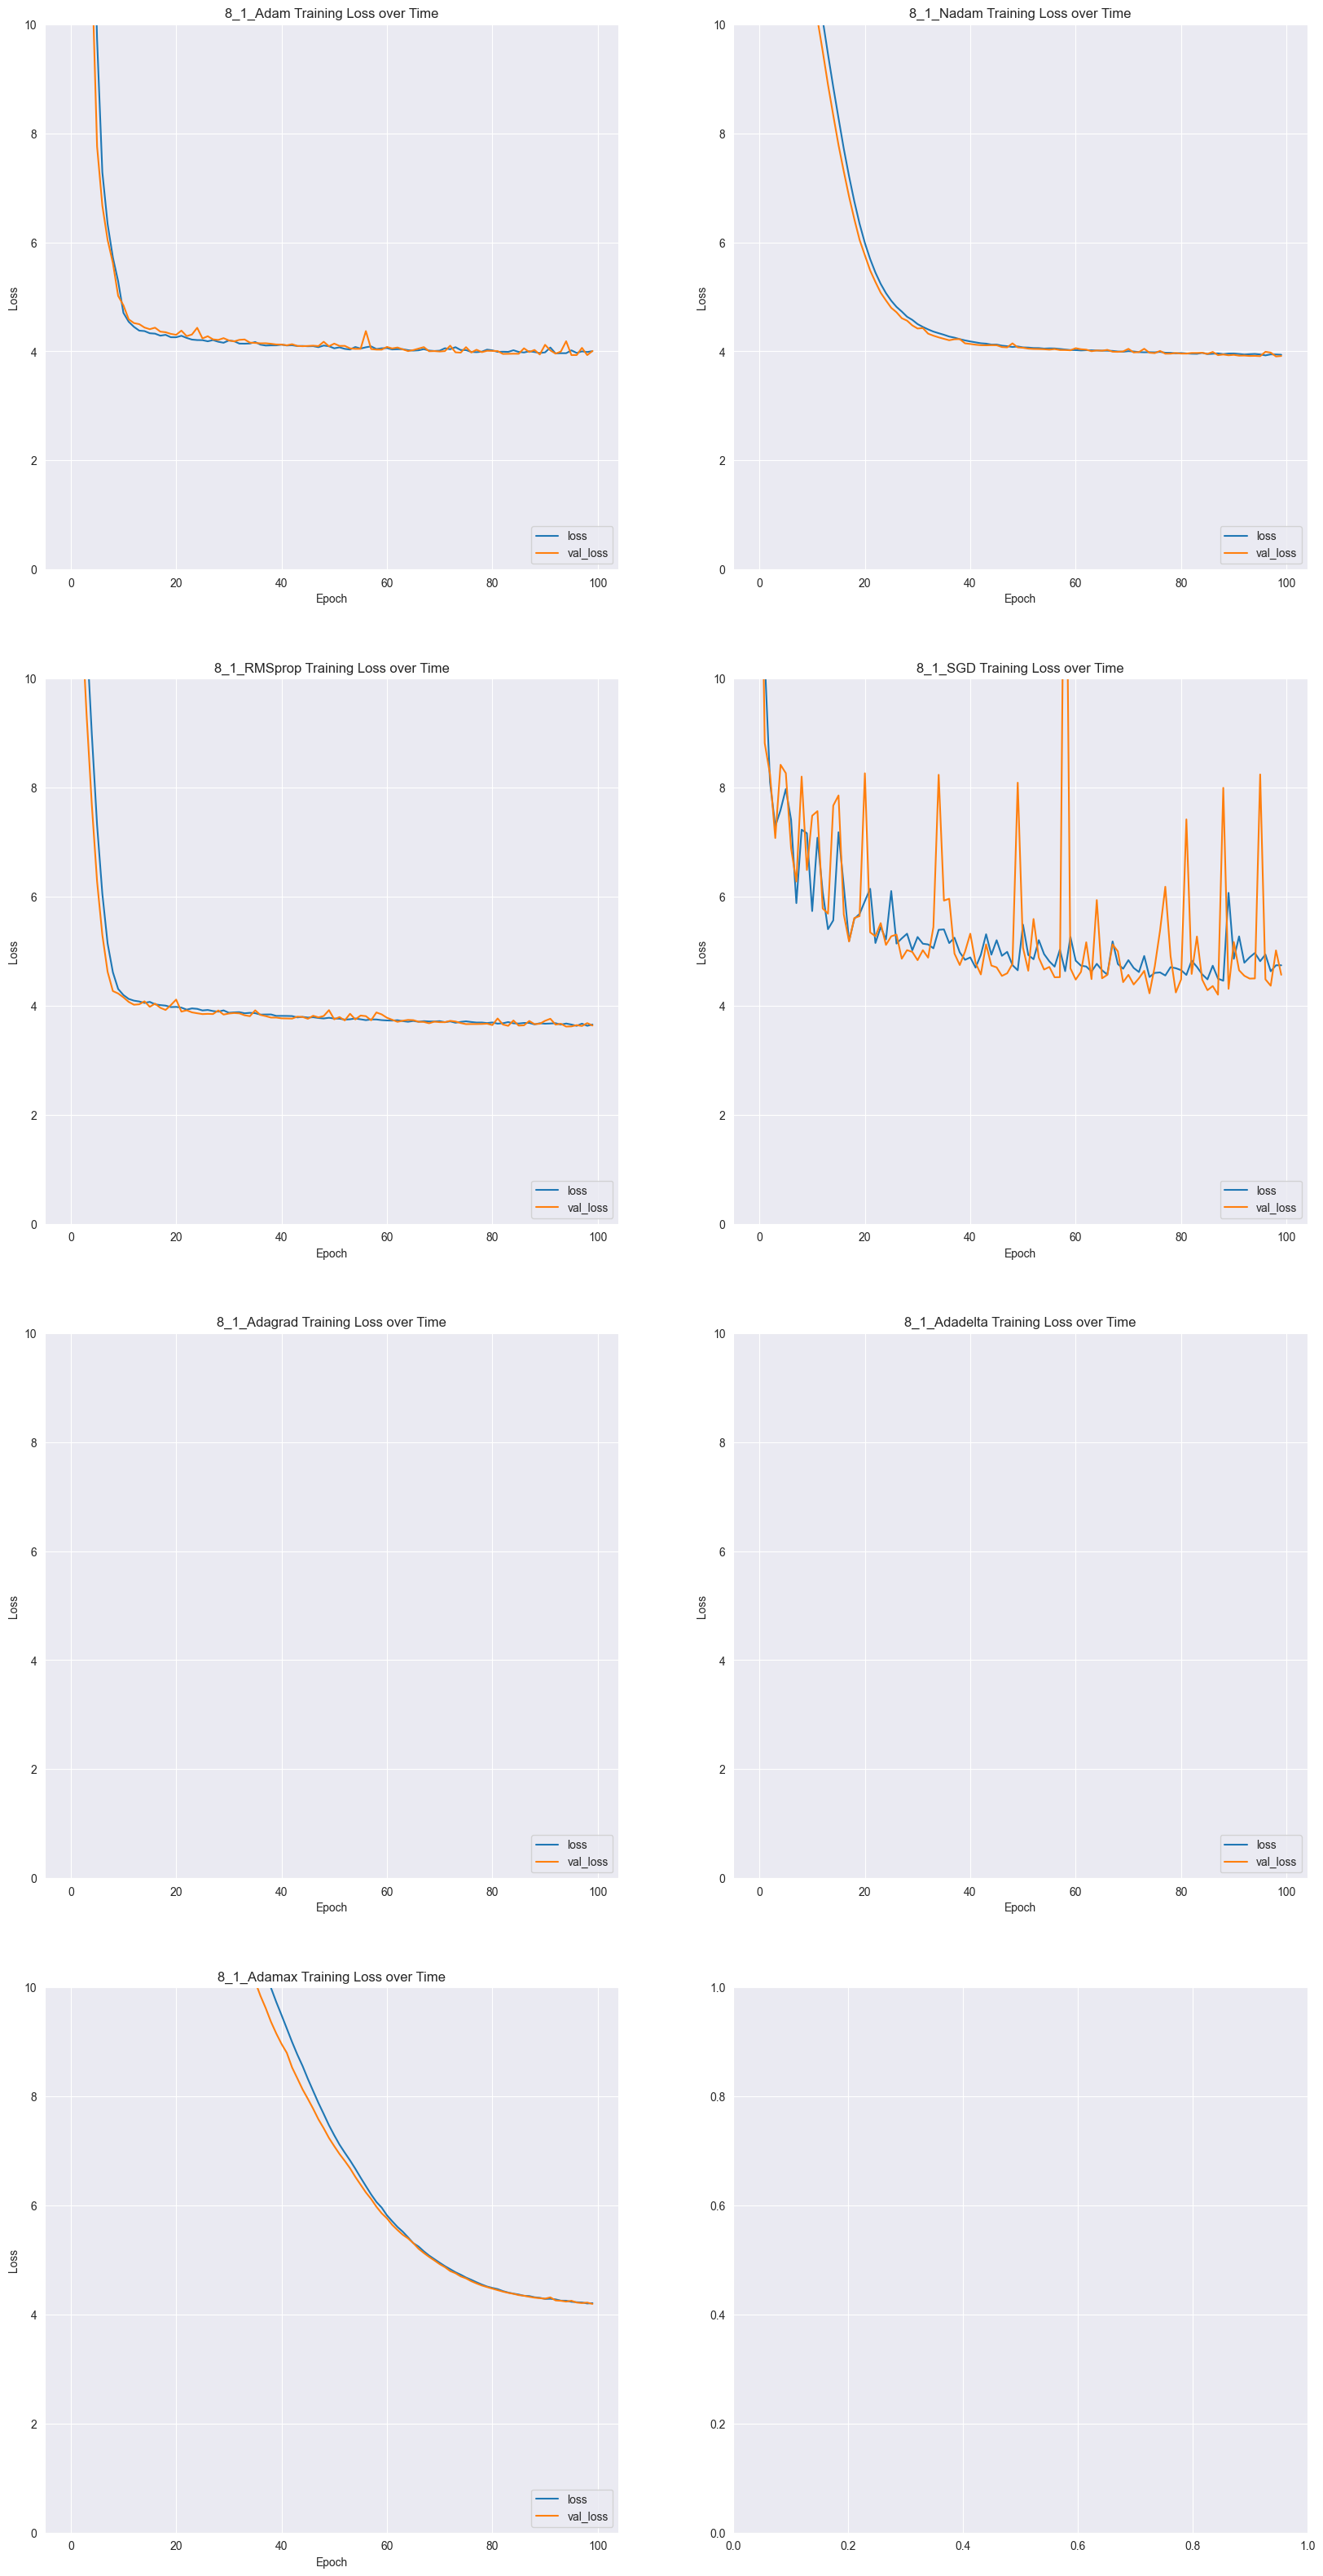

In [73]:
%%time
plot_training_loss_from_dict(optimizer_histories)


#### Optimizer Leaderboard

Based on these training loss plots, I'm leaning towards Adam or Nadam.

Let's compare the scores on the leaderboard again before our final decision.

In [74]:
%%time
optimizer_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_Adam,4.090274,1.535814,0.144033,0.132497
8_1_Nadam,3.965157,1.461784,0.021186,0.018805
8_1_RMSprop,3.789742,1.430566,0.178975,0.178922
8_1_SGD,4.426535,1.589397,-0.444427,-0.453964
8_1_Adagrad,11.848803,2.711921,0.338343,0.246368
8_1_Adadelta,41.268192,5.898095,-0.069903,-5.753660
8_1_Adamax,4.259034,1.536539,-0.064128,-0.064187


#### And the Winner Is...

##### Nadam!

[Nadam](https://keras.io/api/optimizers/Nadam/) has the best mean and squared errors. Its variance is not as good as Adam, but a crab's age has some wiggle room of a year or two because of how data is collected.

Let's tune the learning rate for Nadam next. We'll create a function with new compile options going forward.

In [75]:
%%time
def nadam_compile_options(learning_rate:float=0.001, loss_metric='mean_squared_error'):
    """Wrapper for common_compile_options with Nadam optimizer.

    :param learning_rate: learning rate for Nadam optimizer
    :param loss_metric: loss metric for the model. Default is 'mean_squared_error'.
    """
    return common_compile_options(
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate),
        loss_metric=loss_metric
    )


CPU times: total: 0 ns
Wall time: 0 ns


### Learning Rate Tuning

So far, we've been using a static learning rate of 0.001. Let's try a few different learning rates.

- 0.1
- 0.01
- 0.001
- 0.0001
- Scheduled

#### Learning Rate = 0.1 (Fast Learning)

Let's try a fast learning rate to see if it helps.

In [76]:
%%time
# cloning from Nadam
all_models['8_1_LR_0_1'] = keras.models.clone_model(all_models['8_1_Nadam'])

all_models['8_1_LR_0_1'].compile(**nadam_compile_options(learning_rate=0.1))

deep_8_1_LR_0_1_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_1_LR_0_1.weights.h5'),
    **common_checkpoint_options
)

# initialize history dictionary
learning_rate_histories = {
    '8_1_LR_0_1': all_models['8_1_LR_0_1'].fit(
        **common_fit_options,
        callbacks=[deep_8_1_LR_0_1_checkpoint])}

all_models['8_1_LR_0_1'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.24 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 197 (792.00 B)

CPU times: total: 859 ms
Wall time: 7.86 s


##### Learning Rate = 0.1 Training Loss Plot

We're expecting a quick approximation and a lot of variance.


CPU times: total: 0 ns
Wall time: 8.02 ms


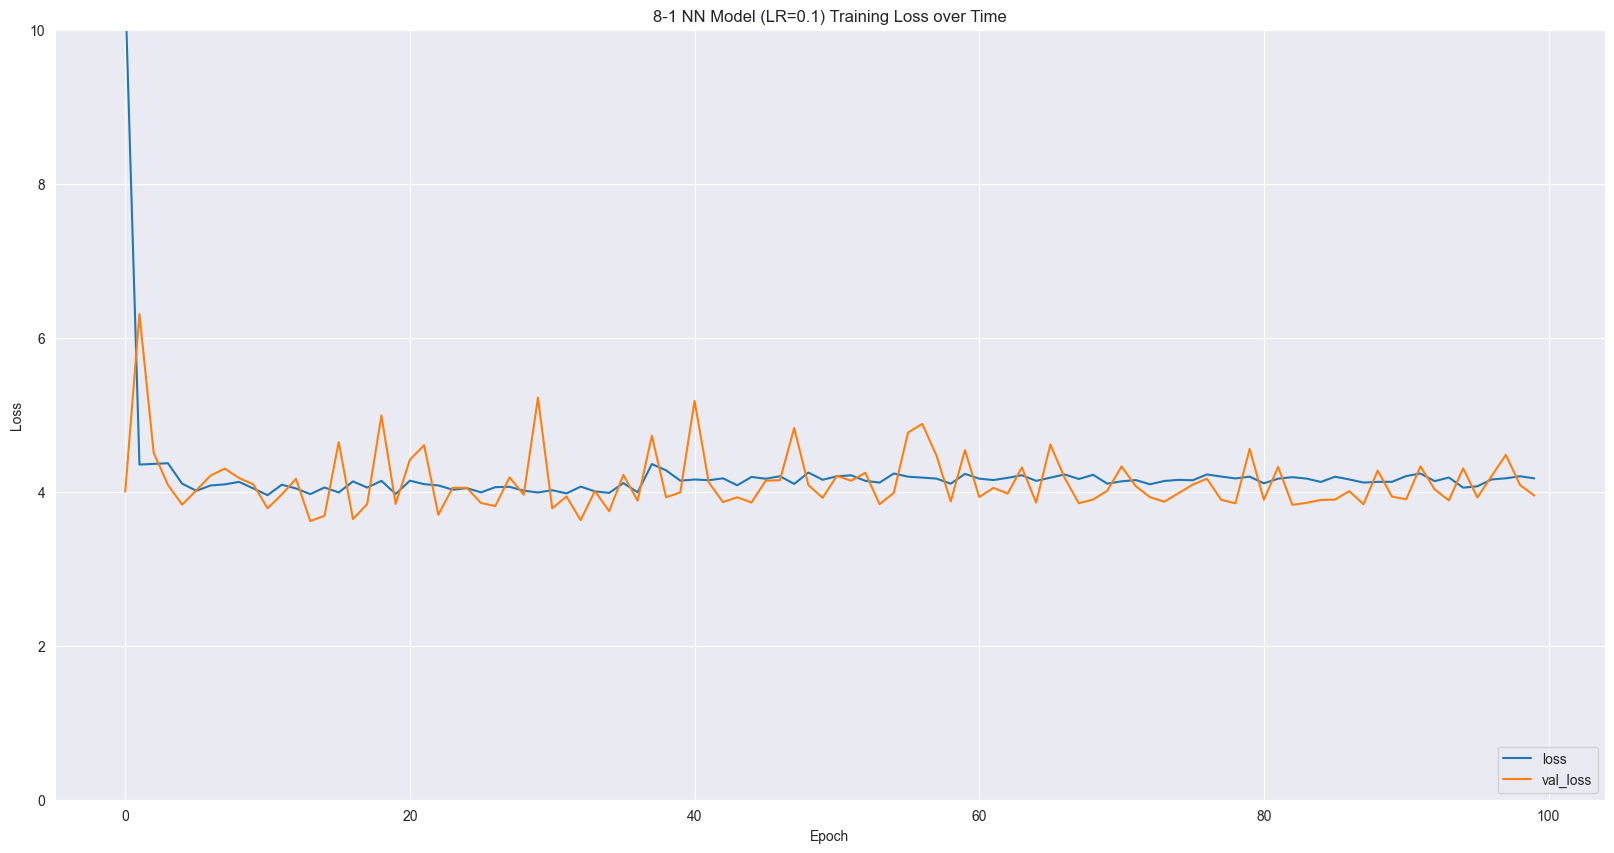

In [77]:
%%time
plot_training_loss(learning_rate_histories['8_1_LR_0_1'], '8-1 NN Model (LR=0.1)')


##### Learning Rate = 0.1 Score

Yikes! That's a lot of variance. Let's try a slower learning rate next. But first, let's put it on the leaderboard.

In [78]:
%%time
chosen_arch_preds = {'8_1_LR_0_1': all_models['8_1_LR_0_1'].predict(X_test).flatten()}
deep_model_scores_df = score_model(chosen_arch_preds['8_1_LR_0_1'], np.array(y_test), index='8_1_LR_0_1')
# Add it to the leaderboard
learning_rate_leaderboard_df = score_combine(pd.DataFrame(), deep_model_scores_df)
learning_rate_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 15.6 ms
Wall time: 84.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_LR_0_1,4.047977,1.539946,0.120075,0.099915


#### Learning Rate = 0.01 (Less Fast Learning)

Still not "slow" learning, but let's decelerate a bit to see if we can address the variance.

In [79]:
%%time
all_models['8_1_LR_0_01'] = keras.models.clone_model(all_models['8_1_Nadam'])

all_models['8_1_LR_0_01'].compile(**nadam_compile_options(learning_rate=0.01))

deep_8_1_LR_0_01_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_1_LR_0_01.weights.h5'),
    **common_checkpoint_options)

learning_rate_histories['8_1_LR_0_01'] = \
    all_models['8_1_LR_0_01'].fit(
        **common_fit_options,
        callbacks=[deep_8_1_LR_0_01_checkpoint])

all_models['8_1_LR_0_01'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.24 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 197 (792.00 B)

CPU times: total: 1.22 s
Wall time: 8.25 s


##### Learning Rate = 0.01 Training Loss Plot

We're looking for a smoother curve with less variance.

CPU times: total: 0 ns
Wall time: 8 ms


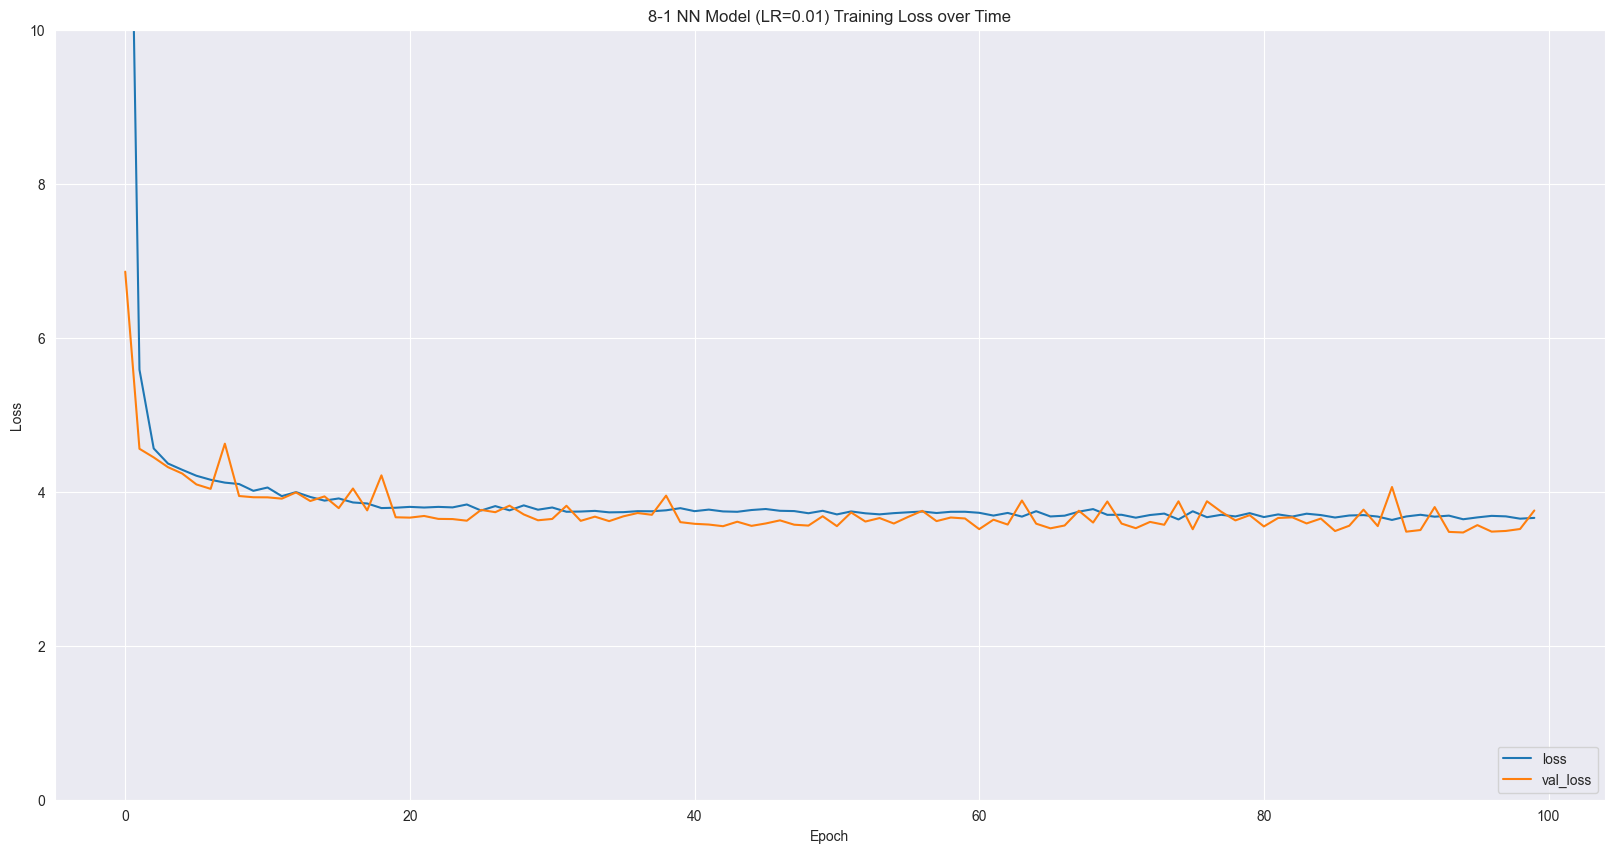

In [80]:
%%time
plot_training_loss(learning_rate_histories['8_1_LR_0_01'], '8-1 NN Model (LR=0.01)')


##### Learning Rate = 0.01 Score

That's more like it. Let's put it on the leaderboard.

In [81]:
%%time
chosen_arch_preds = {'8_1_LR_0_01': all_models['8_1_LR_0_01'].predict(X_test).flatten()}
deep_model_scores_df = score_model(chosen_arch_preds['8_1_LR_0_01'], np.array(y_test), index='8_1_LR_0_01')
# Add it to the leaderboard
learning_rate_leaderboard_df = score_combine(learning_rate_leaderboard_df, deep_model_scores_df)
learning_rate_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 0 ns
Wall time: 88.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_LR_0_1,4.047977,1.539946,0.120075,0.099915
8_1_LR_0_01,4.030183,1.546922,0.325183,0.285862


#### Learning Rate = 0.001 (Slow Learning)

This is the learning rate we've been using, so we know what to expect.

Let's confirm our expectations and see how it compares to the others.


In [82]:
%%time
all_models['8_1_LR_0_001'] = keras.models.clone_model(all_models['8_1_Nadam'])

all_models['8_1_LR_0_001'].compile(**nadam_compile_options(learning_rate=0.001))

deep_8_1_LR_0_001_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_1_LR_0_001.weights.h5'),
    **common_checkpoint_options)

learning_rate_histories['8_1_LR_0_001'] = \
    all_models['8_1_LR_0_001'].fit(
        **common_fit_options,
        callbacks=[deep_8_1_LR_0_001_checkpoint])

all_models['8_1_LR_0_001'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.24 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 197 (792.00 B)

CPU times: total: 1.31 s
Wall time: 8 s


##### Learning Rate = 0.001 Training Loss Plot

This should look familiar.


CPU times: total: 0 ns
Wall time: 8.51 ms


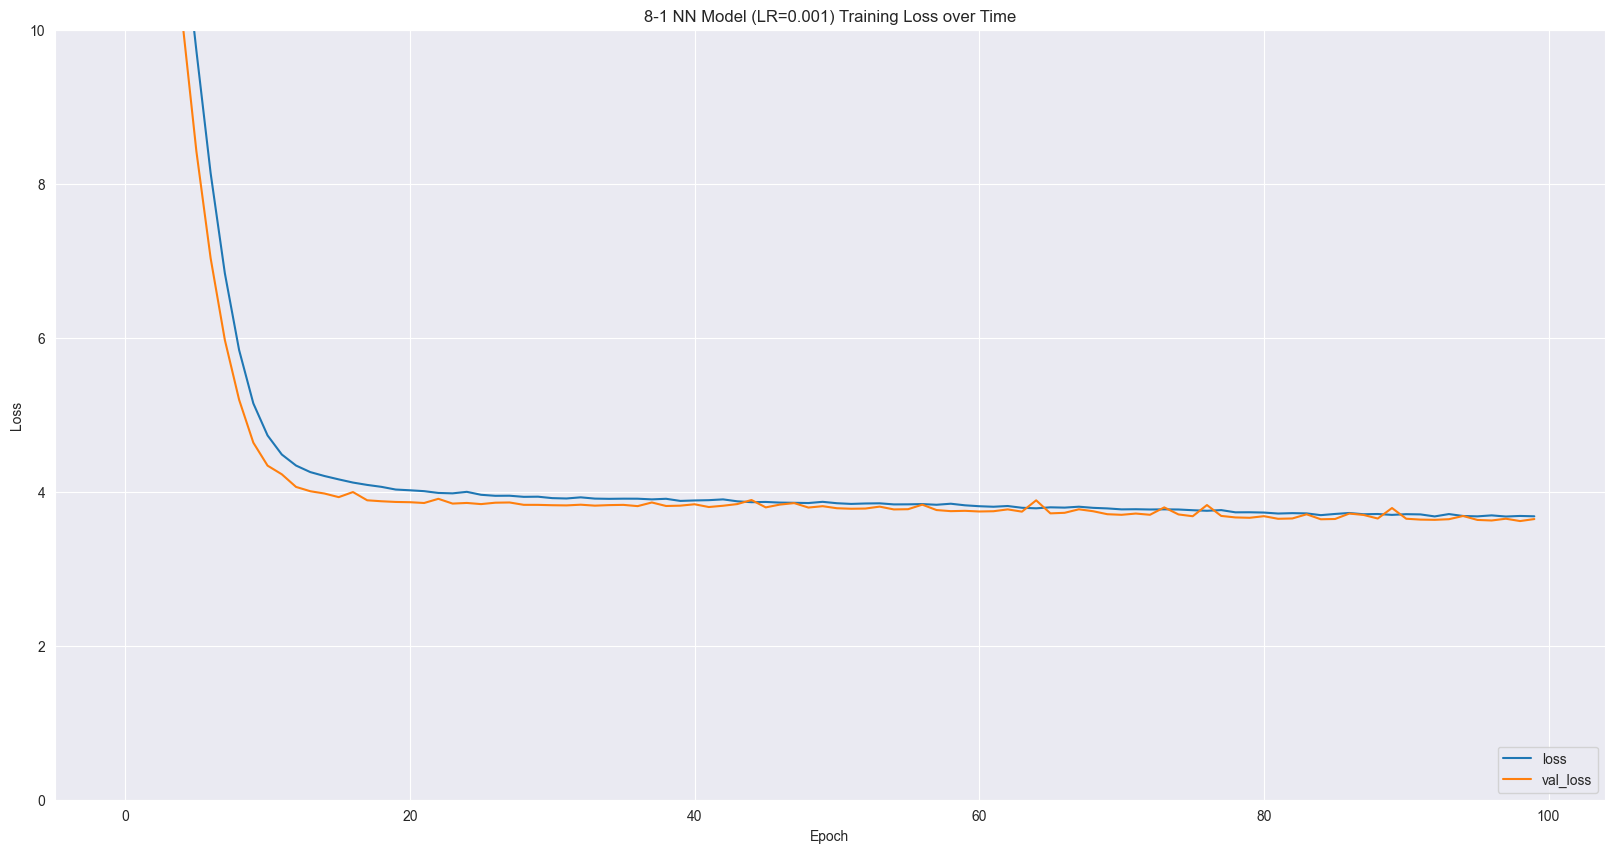

In [83]:
%%time
plot_training_loss(learning_rate_histories['8_1_LR_0_001'], '8-1 NN Model (LR=0.001)')


##### Learning Rate = 0.001 Score

Add it to the leaderboard.

In [84]:
%%time
chosen_arch_preds = {'8_1_LR_0_001': all_models['8_1_LR_0_001'].predict(X_test).flatten()}
deep_model_scores_df = score_model(chosen_arch_preds['8_1_LR_0_001'], np.array(y_test), index='8_1_LR_0_001')
# Add it to the leaderboard
learning_rate_leaderboard_df = score_combine(learning_rate_leaderboard_df, deep_model_scores_df)
learning_rate_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 31.2 ms
Wall time: 86.7 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_LR_0_1,4.047977,1.539946,0.120075,0.099915
8_1_LR_0_01,4.030183,1.546922,0.325183,0.285862
8_1_LR_0_001,3.810170,1.414032,0.104164,0.099028


#### Learning Rate = 0.0001 (Slower Learning)

Let's slow down the learning rate even more. It might take a while to converge, but we expect less variance.

In [85]:
%%time
all_models['8_1_LR_0_0001'] = keras.models.clone_model(all_models['8_1_Nadam'])

all_models['8_1_LR_0_0001'].compile(**nadam_compile_options(learning_rate=0.0001))

deep_8_1_LR_0_0001_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_1_LR_0_0001.weights.h5'),
    **common_checkpoint_options)

learning_rate_histories['8_1_LR_0_0001'] = \
    all_models['8_1_LR_0_0001'].fit(
        **common_fit_options,
        callbacks=[deep_8_1_LR_0_0001_checkpoint])

all_models['8_1_LR_0_0001'].summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.24 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 197 (792.00 B)

CPU times: total: 2.02 s
Wall time: 8.67 s


##### Learning Rate = 0.0001 Training Loss Plot

This should be a slow and steady curve.

CPU times: total: 156 ms
Wall time: 193 ms


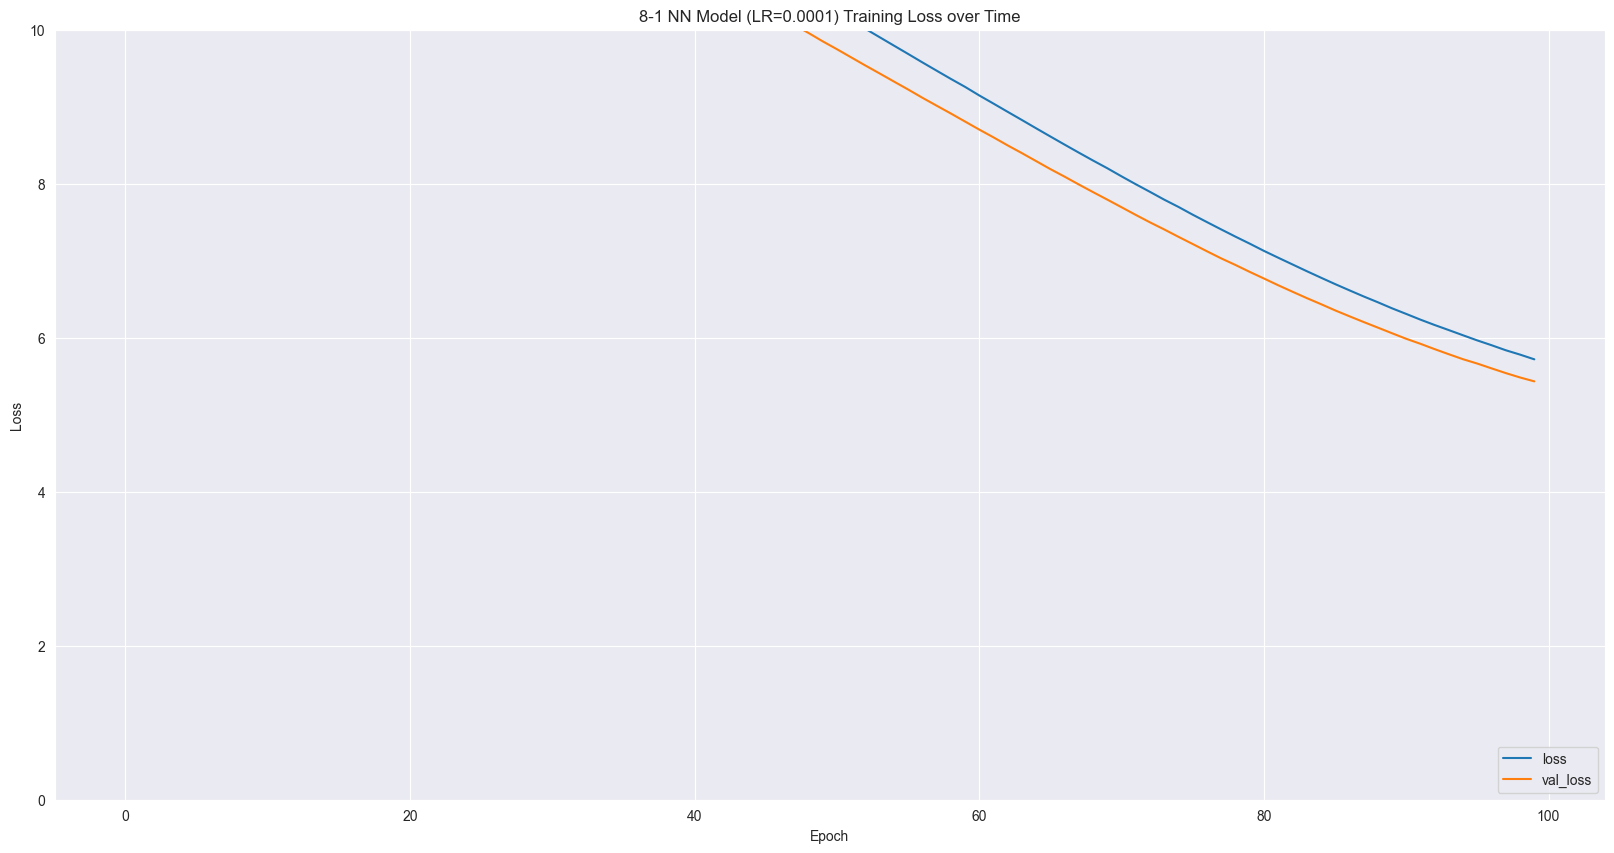

In [86]:
%%time
plot_training_loss(learning_rate_histories['8_1_LR_0_0001'], '8-1 NN Model (LR=0.0001)')


##### Learning Rate = 0.0001 Score

This one is acting as expected. In an ideal world, we would give every model more epochs,
but for the sake of time, we'll stick to 100 epochs and consider this 'too slow' for this project.

In [87]:
%%time
chosen_arch_preds = {'8_1_LR_0_0001': all_models['8_1_LR_0_0001'].predict(X_test).flatten()}
deep_model_scores_df = score_model(chosen_arch_preds['8_1_LR_0_0001'], np.array(y_test), index='8_1_LR_0_0001')
# Add it to the leaderboard
learning_rate_leaderboard_df = score_combine(learning_rate_leaderboard_df, deep_model_scores_df)
learning_rate_leaderboard_df.sort_index()[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 90.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_LR_0_0001,5.736784,1.776612,0.167715,0.135884
8_1_LR_0_001,3.810170,1.414032,0.104164,0.099028
8_1_LR_0_01,4.030183,1.546922,0.325183,0.285862
8_1_LR_0_1,4.047977,1.539946,0.120075,0.099915


#### Scheduled Learning Rate

Let's use what we learned from [simulated annealing](https://github.com/ahester57/ai_workshop/tree/master/notebooks/simulated_annealing) to schedule the learning rate.

Learning rate (0.01) has the best scores so far.

Our scheduled learning rate can start here and decrease by $X$% every $Y$ epochs of no improvement.

We learned from an earlier experiment that these networks commonly plateau but continue to learn after a while, so we want to give it a chance to learn.

We'll use a [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) callback to adjust the learning rate based on the validation loss.

- *Factor = 0.75*: The factor by which the learning rate will be reduced. new_lr = lr * factor.
- *Patience = 9*: Number of epochs with no improvement after which learning rate will be reduced.

These values were chosen based on some experimentation (not shown here for brevity).

*I wonder if we can schedule the schedule's schedule... (We can, but we won't here.)*


In [88]:
%%time
all_models['8_1_LR_S'] = keras.models.clone_model(all_models['8_1_Nadam'])

all_models['8_1_LR_S'].compile(**nadam_compile_options(learning_rate=0.01))

deep_8_1_LR_S_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_1_LR_S.weights.h5'),
    **common_checkpoint_options
)

learning_rate_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75,
    patience=9,
    verbose=1,
    mode='min'
)

learning_rate_histories['8_1_LR_S'] = \
    all_models['8_1_LR_S'].fit(
        **common_fit_options,
        callbacks=[deep_8_1_LR_S_checkpoint, learning_rate_schedule])

all_models['8_1_LR_S'].summary()



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.24 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 197 (792.00 B)

CPU times: total: 938 ms
Wall time: 7.87 s


##### Learning Rate Schedule Training Loss Plot

Let's look for an improvement in the training loss rate over epochs.


CPU times: total: 0 ns
Wall time: 7.52 ms


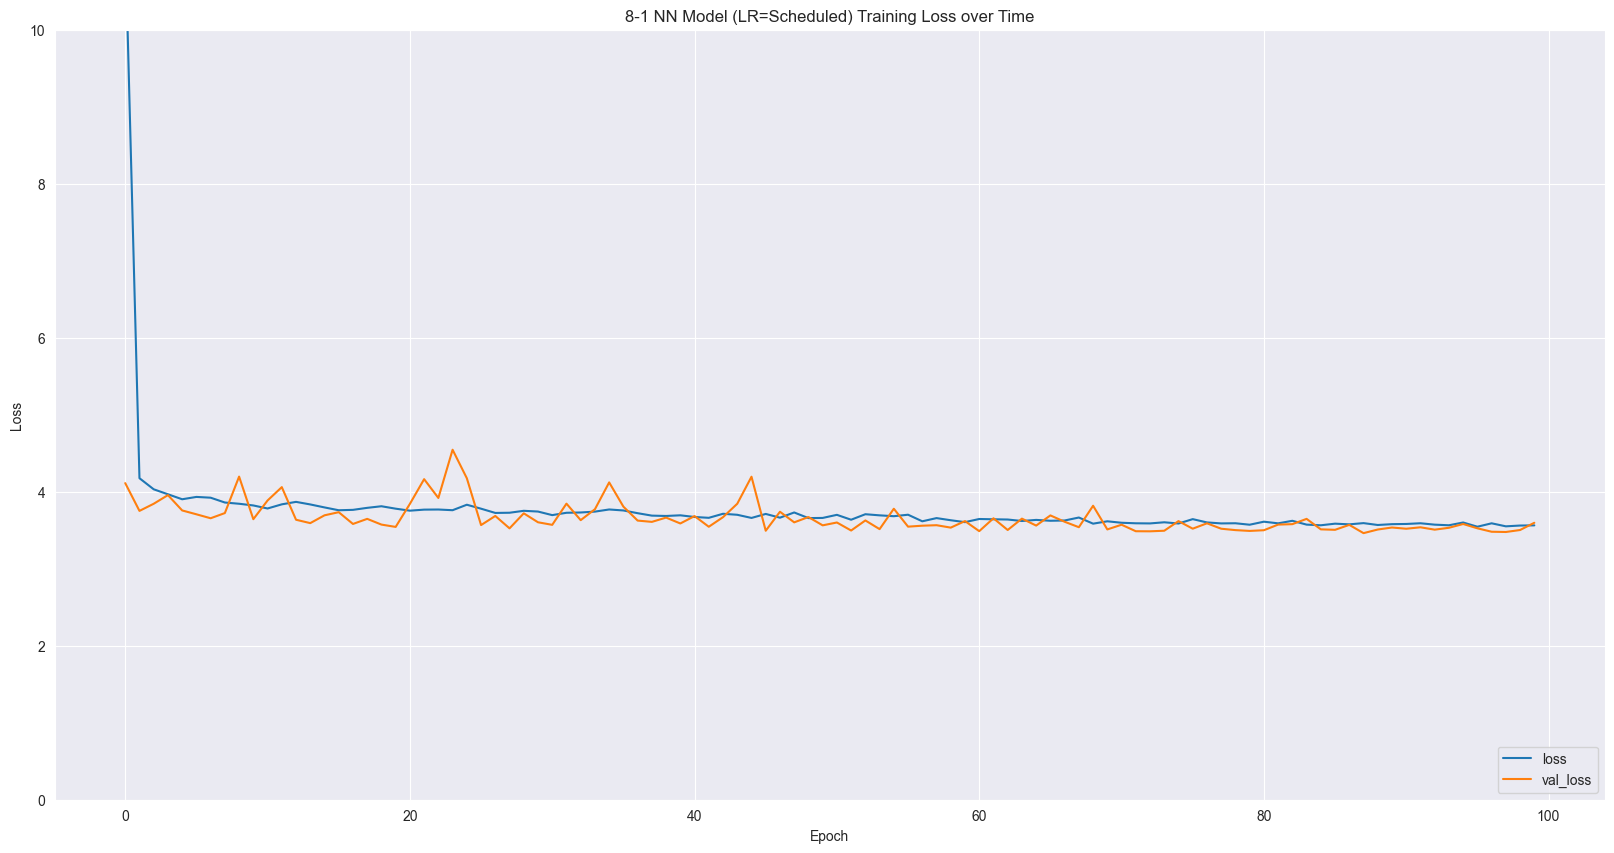

In [89]:
%%time
plot_training_loss(learning_rate_histories['8_1_LR_S'], '8-1 NN Model (LR=Scheduled)')


##### Scheduled Learning Rate Score

In [90]:
%%time
chosen_arch_preds = {'8_1_LR_S': all_models['8_1_LR_S'].predict(X_test).flatten()}
deep_model_scores_df = score_model(chosen_arch_preds['8_1_LR_S'], np.array(y_test), index='8_1_LR_S')
# Add it to the leaderboard
learning_rate_leaderboard_df = score_combine(learning_rate_leaderboard_df, deep_model_scores_df)
learning_rate_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 62.5 ms
Wall time: 96.2 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_LR_0_1,4.047977,1.539946,0.120075,0.099915
8_1_LR_0_01,4.030183,1.546922,0.325183,0.285862
8_1_LR_0_001,3.810170,1.414032,0.104164,0.099028
8_1_LR_0_0001,5.736784,1.776612,0.167715,0.135884
8_1_LR_S,3.804682,1.401184,0.096264,0.076453


*Winner winner, crab's for dinner!*

The scheduled learning rate is the best so far. But not so fast, let's take a look at the big picture.

### Learning Rate Decision

Let's compare the training loss plots and the leaderboard scores for all the learning rates.

Reminder of our criteria:

- Mean Absolute Error within 2 years.
- Reasonable Explained Variance Score
- Reasonable R2 Score
- Avoid Overfitting
- Reasonable Learning Rate

#### Learning Rate Training Loss Plots

CPU times: total: 15.6 ms
Wall time: 45.1 ms


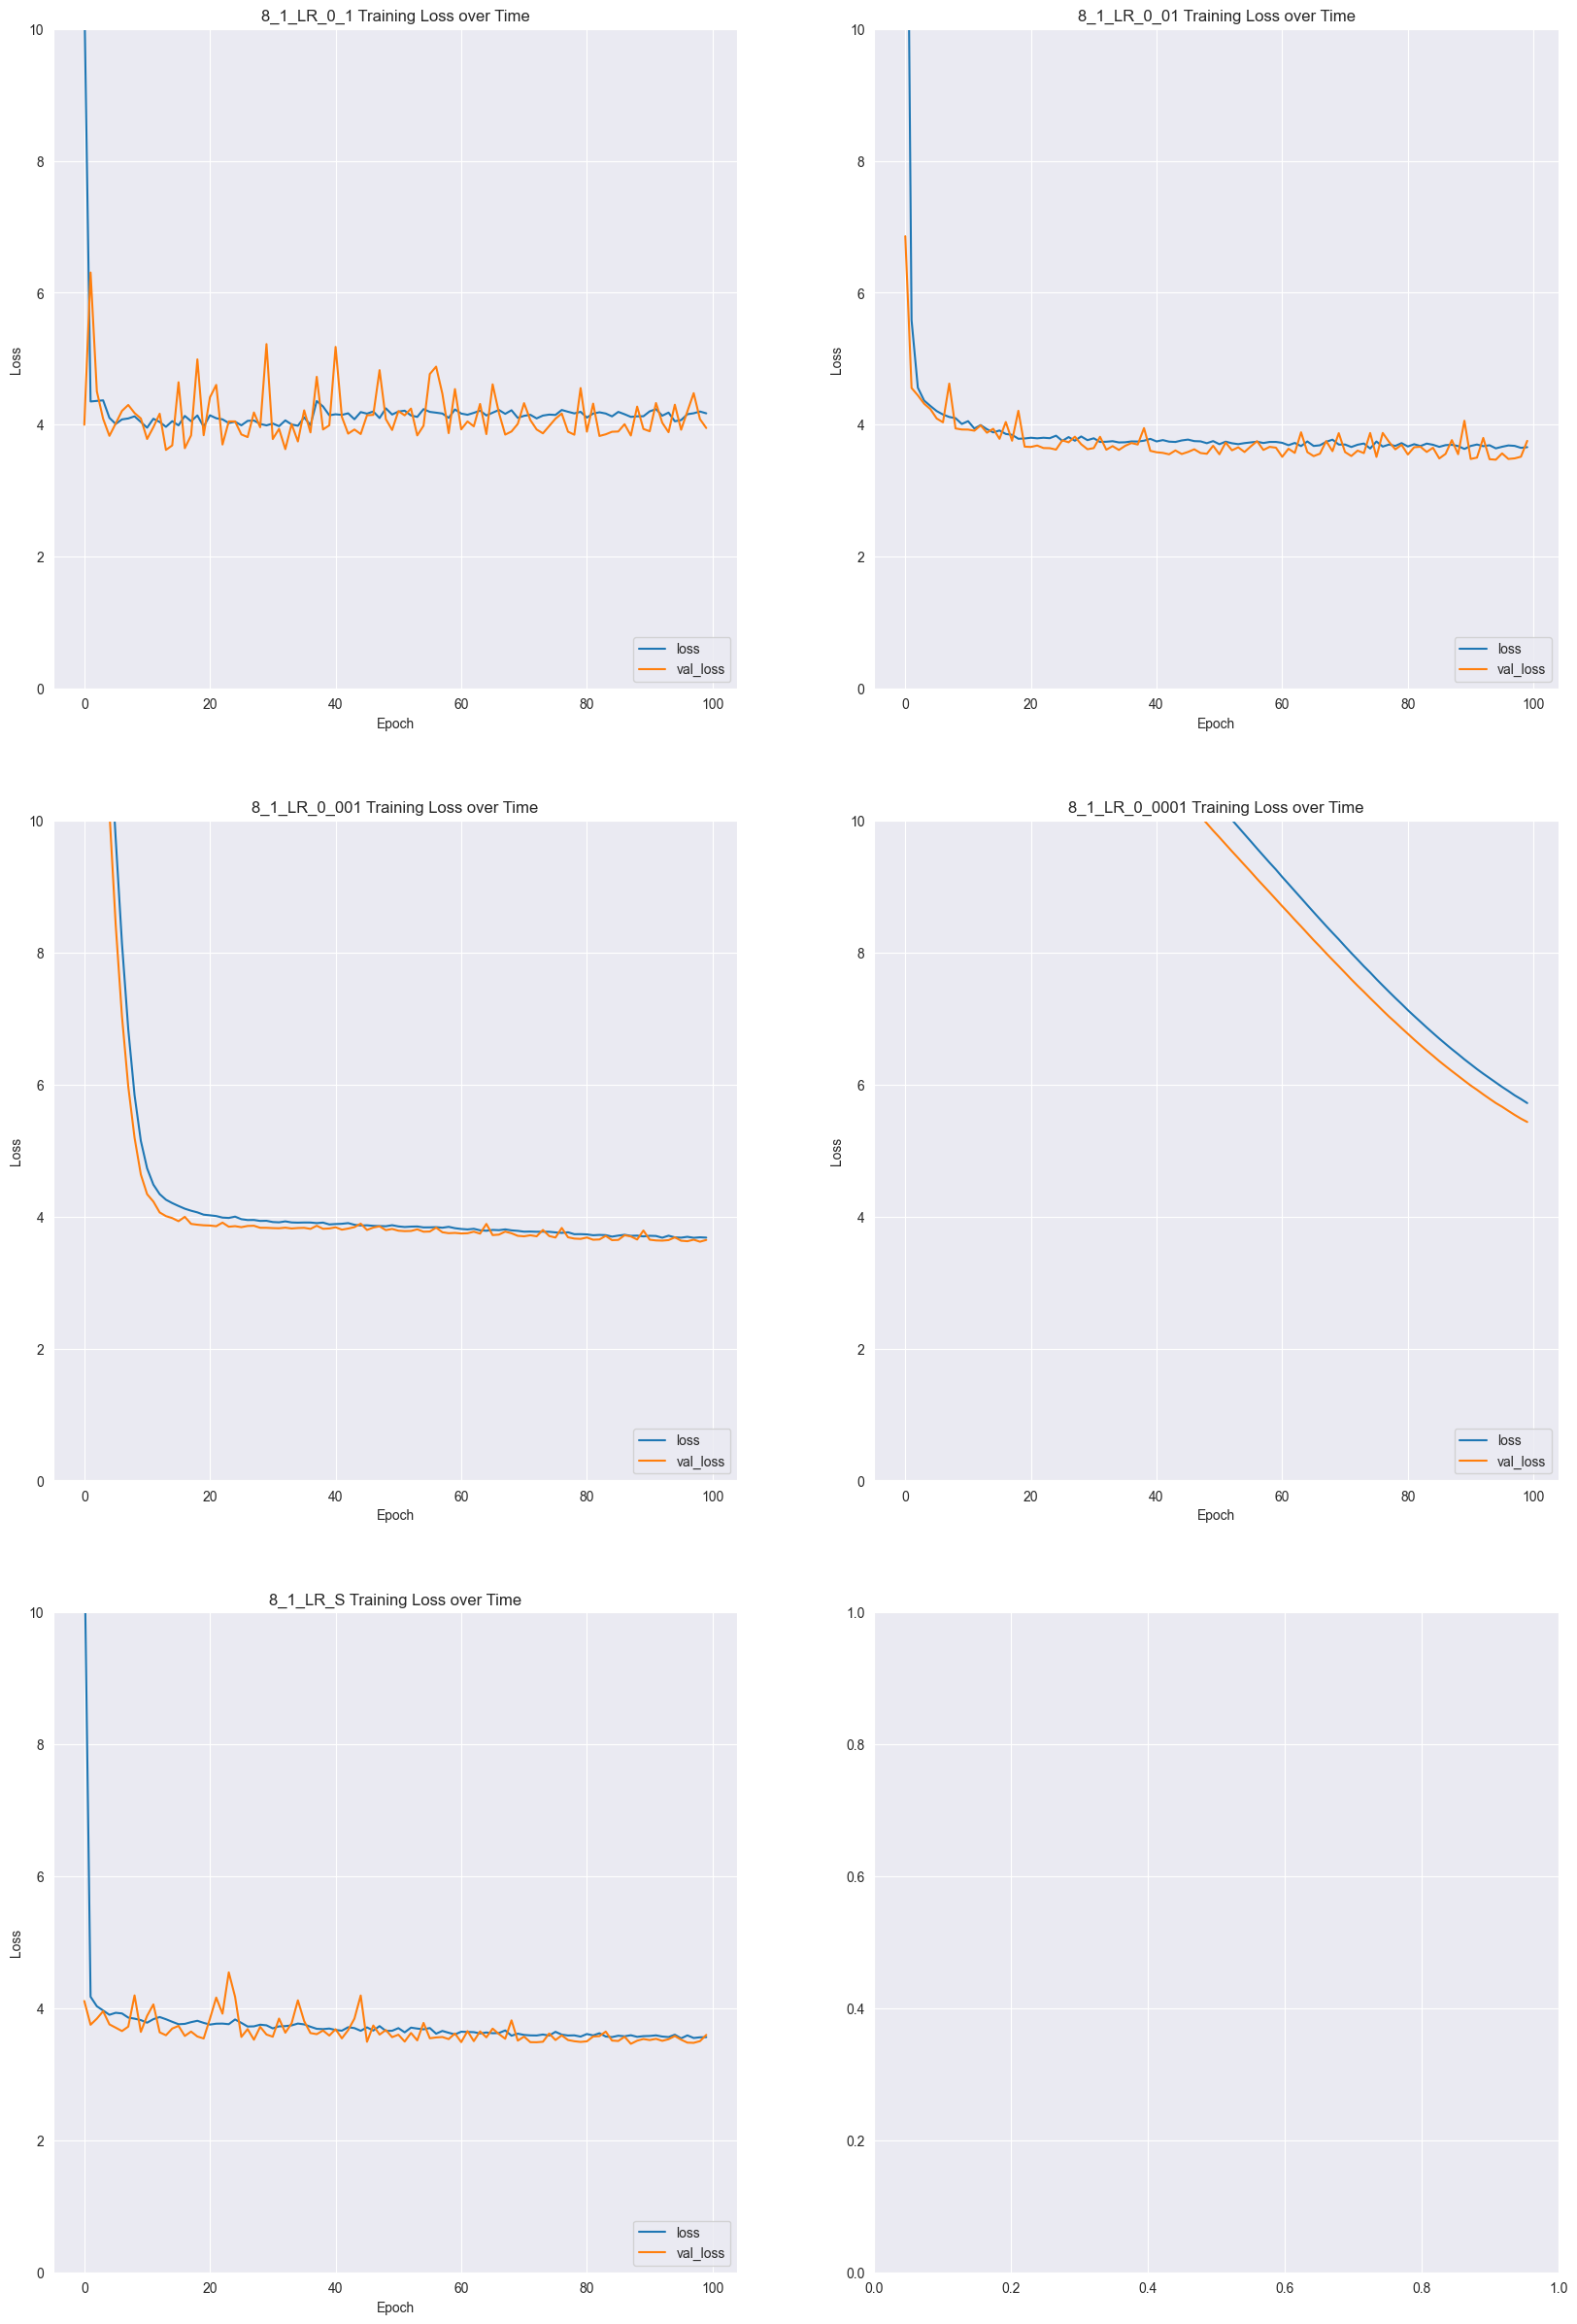

In [91]:
%%time
plot_training_loss_from_dict(learning_rate_histories)


#### Learning Rate Leaderboard

Check the leaderboard again before the big decision.

In [92]:
%%time
learning_rate_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_LR_0_1,4.047977,1.539946,0.120075,0.099915
8_1_LR_0_01,4.030183,1.546922,0.325183,0.285862
8_1_LR_0_001,3.810170,1.414032,0.104164,0.099028
8_1_LR_0_0001,5.736784,1.776612,0.167715,0.135884
8_1_LR_S,3.804682,1.401184,0.096264,0.076453


#### And the Winner Is...

##### Scheduled Learning Rate!

Spending a little extra time on the learning rate paid off. It has the best error scores and the acceptable variance.

Specifically, we are using [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) for our schedule.

- *Factor = 0.75*: The factor by which the learning rate will be reduced. new_lr = lr * factor.
- *Patience = 9*: Number of epochs with no improvement after which learning rate will be reduced.

Others exist (like [ExponentialDecay](https://keras.io/api/optimizers/schedules/exponential_decay/)), but this one worked well for us.

So far we have chosen the (8-1) neural network architecture with the Nadam optimizer and a scheduled learning rate.


### Loss Function to Mean Absolute Error

Let's try a different loss function to see if it improves the model.

- **Loss Function**
    - Mean Absolute Error (MAE)
        - Less sensitive to outliers.
        - Penalizes all errors equally.

This could be good for our model, as we removed outliers in the data cleaning step. Let's find out.

We'll keep the best architecture so far and change the loss function to MAE.


In [93]:
%%time
all_models['8_1_MAE'] = keras.models.clone_model(all_models['8_1_LR_S'])

all_models['8_1_MAE'].compile(**nadam_compile_options(
    learning_rate=0.01,
    loss_metric='mean_absolute_error'))

deep_8_1_MAE_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_8_1_MAE.weights.h5'),
    **common_checkpoint_options
)

loss_histories = {'8_1_MAE': 
    all_models['8_1_MAE'].fit(
        **common_fit_options,
        callbacks=[deep_8_1_MAE_checkpoint, learning_rate_schedule])}

all_models['8_1_MAE'].summary()



Epoch 43: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.24 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 197 (792.00 B)

CPU times: total: 2.77 s
Wall time: 8.17 s


#### Lost Function Mean Absolute Error Training Loss Plot

***Note**: The loss function is different, so the scale will be different.*


CPU times: total: 0 ns
Wall time: 8.01 ms


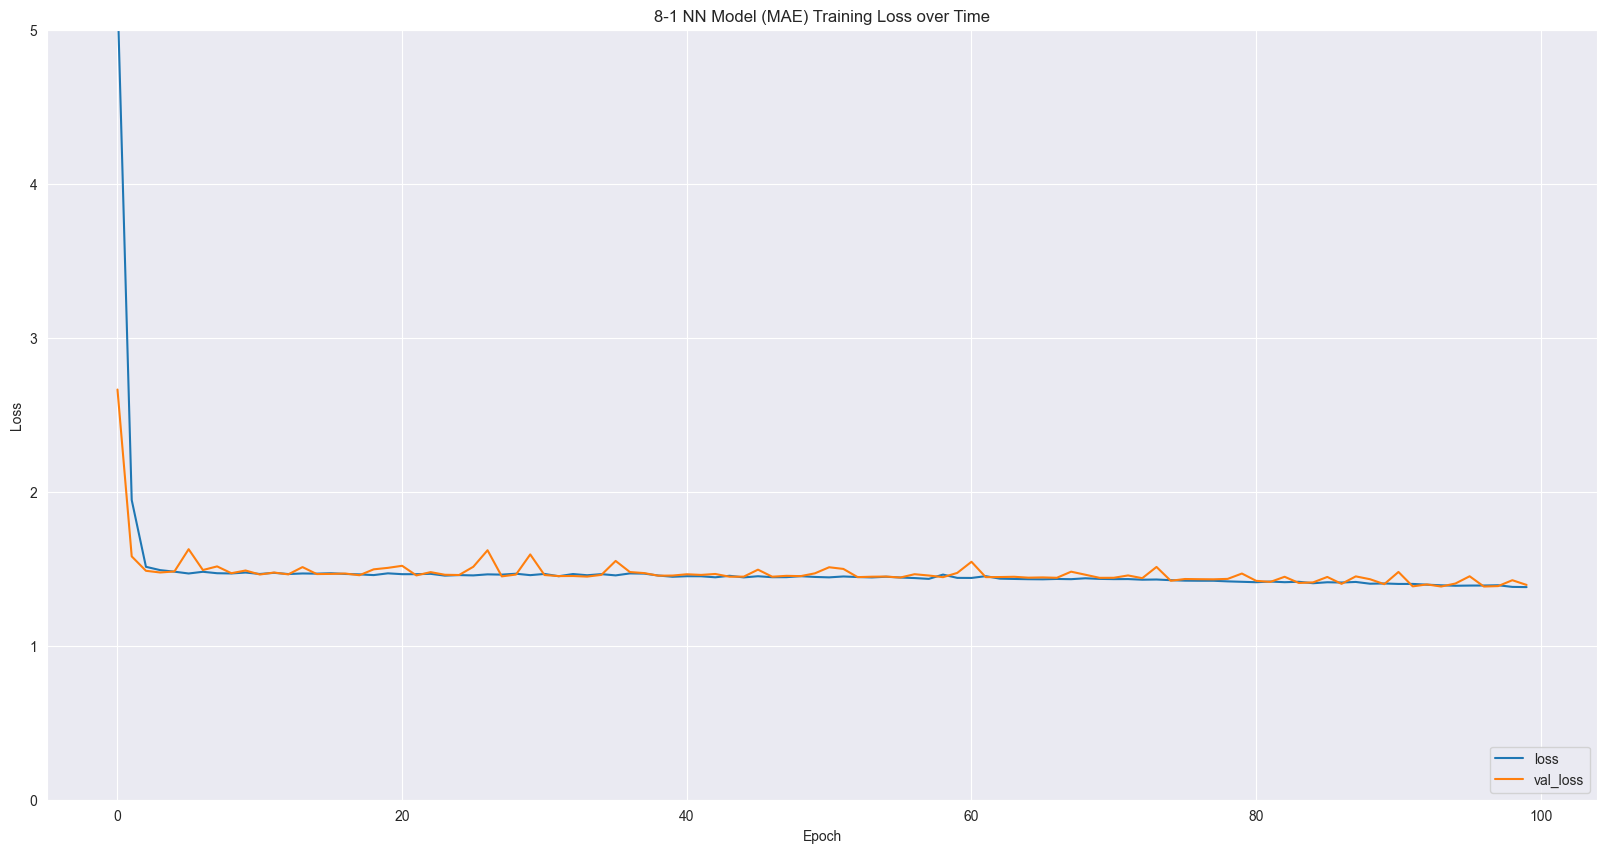

In [94]:
%%time
plot_training_loss(loss_histories['8_1_MAE'], '8-1 NN Model (MAE)', y_lim=(0, 5))


#### Loss Function = Mean Absolute Error Score

We can't tell anything yet since it's a new scale. Let's check out the leaderboard with all the metrics.


In [95]:
%%time
chosen_arch_preds['8_1_MAE'] = all_models['8_1_MAE'].predict(X_test).flatten()
deep_model_scores_df = score_model(chosen_arch_preds['8_1_MAE'], np.array(y_test), index='8_1_MAE')
# Add it to the leaderboard
loss_leaderboard_df = score_combine(learning_rate_leaderboard_df.loc[['8_1_LR_S']], deep_model_scores_df)
loss_leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 31.2 ms
Wall time: 89.6 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
8_1_LR_S,3.804682,1.401184,0.096264,0.076453
8_1_MAE,4.017355,1.415679,0.074722,0.034409


#### Mean Absolute Error Loss Function Observations

Not the improvement we were looking for. Consistently lagging behind the model trained with Mean Squared Error (MSE) loss.


### Perhaps an Ensemble Will Help

But I'm running out of time. Let's move on to feature engineering with our best model so far.

## Winner, Winner, Crab's for Dinner!

### Our Best Model So Far

- Architecture: (8-1) Neural Network
- Optimizer: Nadam
- Learning Rate: Scheduled
    - Start = 0.01 
    - Factor = 0.75
    - Patience = 9 epochs 
- Loss Function: Mean Squared Error


## Save the Data

So we can pick this back up on the [next step](../2-features/features.ipynb).


In [96]:
%%time
# save the training and test data separately
pd.concat([X_train, y_train], axis=1, join='outer').to_feather(NEXT_CACHE_FILE)
pd.concat([X_test, y_test], axis=1, join='outer').to_feather(NEXT_CACHE_FILE.replace('.feather', '_test.feather'))


CPU times: total: 0 ns
Wall time: 6.51 ms


## Onwards to Feature Engineering

See the [next section](../2-features/features.ipynb) for feature engineering.

[`<html link>`](https://nbviewer.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/2-features/features.ipynb) for feature reduction.
